## Present tense fiction (revision)

DONE:
        
        1. Check the trend indicating an increase or decrease in the use of present tense in Dutch literature over the past two decades - Kendall-tau test is done and Pearson correlation
        2. The ANOVA test is done to see if there are significant differences between genres in terms of the use of tenses: there are significant differences. I wanted to look deeper in these differences with Games-Howell Test, but I probably do somthing wrong, it does not work.
        3. The regressions are redone, to fight collinearity I have done two regressions without num_tokens and unique_token_count for all books and specifically for Literary fiction; and I have also done Lasso regression (reduces the big predictors such as num_counts and balances them in such a way if I understand it correctly), the Lasso regressions are also done for both all books and apart for literary fiction.
        4. The pronouns are redone for the whole dataset (there is something with ik and hij separate counts, but I hope I managed to count other pronouns correctly). There are just slightly more first-person pronouns in present tense literature, but significantly less third-person pronouns in comparison with books written in past tense! 

### Download and read books

In [1]:
%reload_ext autoreload
%autoreload 2

import glob
import gzip
import json
import os

import pandas as pd


def get_book_chunk_files(isbn, data_dir):
    return glob.glob(os.path.join(data_dir, f'{isbn}/*.json.gz'))


def read_book_tokens(isbn, data_dir):
    book_chunk_files = get_book_chunk_files(isbn, data_dir)
    book_chunks = read_book_chunk_files(book_chunk_files)
    book_tokens = []
    sent_num = 0
    for ci, chunk in enumerate(book_chunks):
        for sentence in chunk['sentences']:
            for token in sentence['tokens']:
                token['isbn'] = isbn
                token['chunk'] = ci
                token['sent_num'] = sent_num
                token['sent_id'] = sentence['id']
                book_tokens.append(token)
            sent_num +=1
    return book_tokens

    
def read_book_chunk_files(book_chunk_files):
    for book_chunk_file in book_chunk_files:
        yield read_book_chunk_file(book_chunk_file)

    
def read_book_chunk_file(book_chunk_file):
    with gzip.open(book_chunk_file, 'rt') as fh:
        book_chunk = json.load(fh)
    return book_chunk


# hier moet je het pad naar de data invullen
data_dir = '/Users/katjat/Desktop/Research/Present_tense_fiction/txts_trankit_parsed'
# hier moet je het pad naar de metadata invullen
work_file = '/Users/katjat/Desktop/Research/Present_tense_fiction/work_isbn_nur_genre.tsv'

This creates a list of all isbns for which the book text has been parsed by Trankit:

In [2]:
book_dirs = glob.glob(os.path.join(data_dir, '*'))
isbns = [os.path.split(book_dir)[-1] for book_dir in book_dirs]
parsed_isbns = [isbn for isbn in isbns if len(get_book_chunk_files(isbn, data_dir)) > 0]
print('Total number of ISBNs:', len(isbns))
print('Number of parsed ISBNs:', len(parsed_isbns))

Total number of ISBNs: 10921
Number of parsed ISBNs: 2876


Next, the metadata is loaded, which now includes years (when the KB - National Library of the Netherlands catalogue gives a year). Note: year is at work level, where for works with multiple ISBNs and multiple publication years, the earliest year is used.

In [3]:
work_genre = pd.read_csv(work_file, sep='\t', index_col=False, dtype={'brinkman': str, 'unesco': str})
parsed_work = work_genre[work_genre.record_id.isin(parsed_isbns)]
parsed_work.head(2)

,work_id,record_id,record_id_type,work_year,nur,thema,bisac,brinkman,unesco,nur_genre
597,impfic-work-96,9789029579643,isbn,2008.0,['302'],NaN,NaN,['romans en novellen ; vertaald'],['Proza (romans/novellen)'],Literary_fiction
946,impfic-work-145,9789025864279,isbn,2013.0,"['300', '285']",NaN,"['JUV013000', 'JNF006040', 'FIC041000', 'JUV00...","['romans en novellen ; oorspr. - Nederlands', ...","['Proza (romans/novellen)', 'Kinderboeken, str...",Literary_fiction


Than chose meta-info that is needed:

In [4]:
parsed_work = parsed_work[['record_id', 'record_id_type', 'work_year', 'nur', 'nur_genre']]
parsed_work.head(2)

,record_id,record_id_type,work_year,nur,nur_genre
597,9789029579643,isbn,2008.0,['302'],Literary_fiction
946,9789025864279,isbn,2013.0,"['300', '285']",Literary_fiction


So there are some ISBNs for which no year is available:

In [5]:
print('number of ISBNs without (first) work publication year:', len(parsed_work[parsed_work.work_year.isna()]))

number of ISBNs without (first) work publication year: 796


The books are cut up into sections of at least 5,000 words. The EPub of the book contains the text per paragraph. The paragraphs were extracted from the EPub in order and merged together. Once a set of paragraphs exceeds 5000 words, these together form a ‘chunk’, and a subsequent chunk is built from the following paragraphs.

### Get the statistics for the books

In [6]:
len(parsed_isbns)

2876

In [7]:
import numpy as np


def get_all_book_stats(parsed_isbns, data_dir):
    all_stats = []
    for isbn in parsed_isbns:
        book_stats = get_book_stats(isbn, data_dir)
        all_stats.append(book_stats)
    return all_stats
        
def get_book_stats(isbn, data_dir):
    book_chunk_files = get_book_chunk_files(isbn, data_dir)
    book_chunks = [book_chunk for book_chunk in read_book_chunk_files(book_chunk_files)]
    total, present, past, pv = get_verb_count(book_chunks)
    num_tokens, sent_len_mean, sent_len_median, sent_len_stdev, unique_tokens = get_length_stats(book_chunks)
    pron_count, propn_count, det_count = get_funcword_count(book_chunks)
    noun_count, adj_count, adv_count, intj_count = get_uposword_count(book_chunks)
    sconj_count, cconj_count, punct_count = get_gramword_count(book_chunks)
    stats = [isbn, total, present, past, pv, num_tokens, sent_len_mean, sent_len_median, sent_len_stdev, unique_tokens, pron_count, propn_count, det_count, noun_count, adj_count, adv_count, intj_count, sconj_count, cconj_count, punct_count]
    return stats


def get_length_stats(book_chunks):
    sentence_lengths = []
    num_tokens = 0
    unique_tokens = set()
    for chunk in book_chunks:
        for sentence in chunk['sentences']:
            sentence_length = len(sentence['tokens'])
            sentence_lengths.append(sentence_length)
            num_tokens += sentence_length
            unique_tokens.update(token['text'] for token in sentence['tokens'])
    unique_tokens_count = len(unique_tokens)
    sentence_lengths = np.array(sentence_lengths)
    sent_len_mean = sentence_lengths.mean()
    sent_len_median = np.median(sentence_lengths)
    sent_len_stdev = sentence_lengths.std()
    return num_tokens, sent_len_mean, sent_len_median, sent_len_stdev, unique_tokens_count


def get_verb_count(book_chunks):
    present_tense_count = 0
    past_tense_count = 0
    total_verb_count = 0
    total_pv_count = 0

    for chunk in book_chunks:
        for sentence in chunk['sentences']:
            tokens = sentence.get('tokens')
            for token in tokens:
                upos = token.get('upos', '')
                xpos = token.get('xpos', '')

                if upos == 'VERB':
                    total_verb_count += 1
                    if 'pv' in xpos:
                        total_pv_count +=1
                    if 'tgw' in xpos:
                        present_tense_count += 1
                    if 'verl' in xpos:
                        past_tense_count += 1
    return total_verb_count, present_tense_count, past_tense_count, total_pv_count

def get_funcword_count (book_chunks):
    pron_count = 0
    propn_count = 0
    det_count = 0
    
    for chunk in book_chunks:
        for sentence in chunk['sentences']:
            tokens = sentence.get('tokens')
            for token in tokens:
                upos = token.get('upos', '')
                
                if upos == 'PRON':
                    pron_count += 1
                if upos == 'PROPN':
                    propn_count += 1
                if upos == 'DET':
                    det_count += 1
                    
    return pron_count, propn_count, det_count

def get_uposword_count (book_chunks):
    noun_count = 0
    adj_count = 0
    adv_count = 0
    intj_count = 0
    
    for chunk in book_chunks:
        for sentence in chunk['sentences']:
            tokens = sentence.get('tokens')
            for token in tokens:
                upos = token.get('upos', '')
                
                if upos == 'NOUN':
                    noun_count += 1
                if upos == 'ADJ':
                    adj_count += 1
                if upos == 'ADV':
                    adv_count += 1
                if upos == 'INTJ':
                    intj_count += 1
                    
    return noun_count, adj_count, adv_count, intj_count

def get_gramword_count (book_chunks):
    sconj_count = 0
    cconj_count = 0
    punct_count = 0
    
    for chunk in book_chunks:
        for sentence in chunk['sentences']:
            tokens = sentence.get('tokens')
            for token in tokens:
                upos = token.get('upos', '')
                
                if upos == 'SCONJ':
                    sconj_count += 1
                if upos == 'CCONJ':
                    cconj_count += 1
                if upos == 'PUNCT':
                    punct_count += 1
                    
    return sconj_count, cconj_count, punct_count
        
test_isbns = parsed_isbns[:2876]

all_stats = get_all_book_stats(test_isbns, data_dir)

columns = [
    'isbn', 'total_verbs', 'present_verbs', 'past_verbs', 'pv_verbs', 'num_tokens', 'sent_len_mean', 'sent_len_median', 
    'sent_len_stdev', 'unique_tokens_count',
    'pron_count', 'propn_count', 'det_count', 'noun_count', 'adj_count', 'adv_count', 'intj_count', 
    'sconj_count', 'cconj_count', 'punct_count'
]

df = pd.DataFrame(all_stats, columns=columns)
df

,isbn,total_verbs,present_verbs,past_verbs,pv_verbs,num_tokens,sent_len_mean,sent_len_median,sent_len_stdev,unique_tokens_count,pron_count,propn_count,det_count,noun_count,adj_count,adv_count,intj_count,sconj_count,cconj_count,punct_count
0,9789044623550,8142,3982,733,4721,64961,13.104902,11.0,8.644918,6532,7883,1646,5512,8165,3690,5709,193,1384,1788,10116
1,9789021449760,17396,1813,8294,10112,137626,14.880095,13.0,9.083210,13048,17051,4268,12453,19893,8344,9263,259,3241,3978,18610
2,9789029590280,347,124,97,221,2763,13.220096,12.0,7.907926,928,370,85,206,346,195,272,7,38,86,397
3,9789044626674,6145,709,2097,2808,53272,50.446970,30.0,66.529663,9185,5418,2476,4779,7489,3769,4113,51,1113,2221,7033
4,9789021441955,11539,1731,4946,6679,83072,13.071912,12.0,7.084609,6512,12176,2680,5851,8681,4058,7196,373,1847,2179,13462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2871,9789025367572,2884,1328,447,1775,23682,14.511029,12.0,10.602205,4025,3308,950,1838,3738,1319,1543,136,386,670,3376
2872,9789021446561,10610,963,4839,5804,84965,14.222464,12.0,8.933086,8822,9134,3925,8199,12080,4885,5669,221,1828,1796,11670
2873,9789044626865,1026,149,452,601,8346,19.098398,14.0,14.079926,1967,1031,299,742,1089,500,654,24,204,310,1090
2874,9789021441320,11301,1468,4926,6396,88033,14.815382,13.0,8.921631,8312,11504,3180,6968,11090,5015,6588,233,1758,2907,12846


Let's get the ratio's we are interested in. So the present and past ratio:

In [8]:
df['present_ratio'] = df.apply(lambda row: row['present_verbs'] / row['total_verbs'], axis=1)
df['past_ratio'] = df.apply(lambda row: row['past_verbs'] / row['total_verbs'], axis=1)
df['pv_total'] = df.apply(lambda row: row['present_verbs'] + row ['past_verbs'], axis=1)
df['pv_present_ratio']= df.apply(lambda row: row['present_verbs'] / row['pv_total'], axis=1)
df['pv_past_ratio']= df.apply(lambda row: row['past_verbs'] / row['pv_total'], axis=1)
df.T

,0,1,2,3,4,5,6,7,8,9,...,2866,2867,2868,2869,2870,2871,2872,2873,2874,2875
isbn,9789044623550,9789021449760,9789029590280,9789044626674,9789021441955,9789035142718,9789021454689,9789021677132,9789025863524,9789025870133,...,9789029505680,9789038899732,9789025875862,9789038891309,9789021668703,9789025367572,9789021446561,9789044626865,9789021441320,9789021436272
total_verbs,8142,17396,347,6145,11539,3942,13532,3386,4378,10299,...,11803,7664,4380,5166,3101,2884,10610,1026,11301,4273
present_verbs,3982,1813,124,709,1731,1940,1910,549,630,1768,...,2270,1457,881,2344,818,1328,963,149,1468,494
past_verbs,733,8294,97,2097,4946,154,6438,1888,1695,5003,...,4855,3491,2364,570,1154,447,4839,452,4926,2834
pv_verbs,4721,10112,221,2808,6679,2099,8350,2438,2328,6772,...,7134,4948,3245,2917,1973,1775,5804,601,6396,3328
num_tokens,64961,137626,2763,53272,83072,33270,94440,24187,36965,77978,...,92032,58485,31455,44921,23944,23682,84965,8346,88033,29129
sent_len_mean,13.104902,14.880095,13.220096,50.44697,13.071912,17.974068,14.442575,11.059442,16.516979,11.388637,...,11.311701,12.186914,11.392611,15.538222,15.011912,14.511029,14.222464,19.098398,14.815382,11.23804
sent_len_median,11.0,13.0,12.0,30.0,12.0,15.0,12.0,10.0,13.0,10.0,...,9.0,10.0,10.0,12.0,13.0,12.0,12.0,14.0,13.0,10.0
sent_len_stdev,8.644918,9.08321,7.907926,66.529663,7.084609,13.103147,9.00683,5.274637,11.587775,6.649422,...,7.397277,7.93374,6.373001,15.402549,8.184118,10.602205,8.933086,14.079926,8.921631,6.38545
unique_tokens_count,6532,13048,928,9185,6512,4006,6452,2938,6894,6539,...,10843,7742,3457,7235,2886,4025,8822,1967,8312,2401


### Concat the book_stats and meta_data (such as year of publication and the nur-code)

In [18]:
meta_df = pd.merge(parsed_work, df, left_on='record_id', right_on='isbn', how='right')
meta_df.shape

(2876, 30)

In [19]:
meta_df1=meta_df[meta_df.record_id.isna()].isbn.value_counts()
meta_df1

9789021677132    1
9789025859169    1
9789025874278    1
9789025873257    1
9789025870270    1
                ..
9789021669755    1
9789025867416    1
9789021670027    1
9789025856960    1
9789021668703    1
Name: isbn, Length: 342, dtype: int64

Get only the books with known year of publication and nur_genre

In [20]:
meta_df1 = meta_df.dropna(subset=['record_id','work_year']).reset_index()
meta_df1

,index,record_id,record_id_type,work_year,nur,nur_genre,isbn,total_verbs,present_verbs,past_verbs,...,adv_count,intj_count,sconj_count,cconj_count,punct_count,present_ratio,past_ratio,pv_total,pv_present_ratio,pv_past_ratio
0,0,9789044623550,isbn,2013.0,['320'],Other fiction,9789044623550,8142,3982,733,...,5709,193,1384,1788,10116,0.489069,0.090027,4715,0.844539,0.155461
1,1,9789021449760,isbn,2014.0,"['285', '333']",Young_adult,9789021449760,17396,1813,8294,...,9263,259,3241,3978,18610,0.104219,0.476776,10107,0.179381,0.820619
2,3,9789044626674,isbn,2014.0,['301'],Literary_fiction,9789044626674,6145,709,2097,...,4113,51,1113,2221,7033,0.115378,0.341253,2806,0.252673,0.747327
3,4,9789021441955,isbn,2012.0,['305'],Literary_thriller,9789021441955,11539,1731,4946,...,7196,373,1847,2179,13462,0.150013,0.428633,6677,0.259248,0.740752
4,5,9789035142718,isbn,2014.0,['700'],Non-fiction,9789035142718,3942,1940,154,...,1591,37,558,1106,4585,0.492136,0.039066,2094,0.926457,0.073543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733,2871,9789025367572,isbn,2010.0,['302'],Literary_fiction,9789025367572,2884,1328,447,...,1543,136,386,670,3376,0.460472,0.154993,1775,0.748169,0.251831
1734,2872,9789021446561,isbn,2013.0,['305'],Literary_thriller,9789021446561,10610,963,4839,...,5669,221,1828,1796,11670,0.090763,0.456079,5802,0.165977,0.834023
1735,2873,9789044626865,isbn,2014.0,['302'],Literary_fiction,9789044626865,1026,149,452,...,654,24,204,310,1090,0.145224,0.440546,601,0.247920,0.752080
1736,2874,9789021441320,isbn,2011.0,['305'],Literary_thriller,9789021441320,11301,1468,4926,...,6588,233,1758,2907,12846,0.129900,0.435891,6394,0.229590,0.770410


In [21]:
meta_df.columns

Index(['record_id', 'record_id_type', 'work_year', 'nur', 'nur_genre', 'isbn',
       'total_verbs', 'present_verbs', 'past_verbs', 'pv_verbs', 'num_tokens',
       'sent_len_mean', 'sent_len_median', 'sent_len_stdev',
       'unique_tokens_count', 'pron_count', 'propn_count', 'det_count',
       'noun_count', 'adj_count', 'adv_count', 'intj_count', 'sconj_count',
       'cconj_count', 'punct_count', 'present_ratio', 'past_ratio', 'pv_total',
       'pv_present_ratio', 'pv_past_ratio'],
      dtype='object')

In [22]:
meta_df.shape

(2876, 30)

In [23]:
meta_df1.shape

(1738, 31)

In [24]:
meta_df['nur_genre'].value_counts()

Literary_fiction     1792
Children_fiction      238
Non-fiction           161
Literary_thriller     128
Other fiction         122
Young_adult            85
Suspense                7
Name: nur_genre, dtype: int64

In [25]:
meta_df1['nur_genre'].value_counts()

Literary_fiction     1013
Children_fiction      234
Non-fiction           160
Literary_thriller     121
Other fiction         120
Young_adult            83
Suspense                7
Name: nur_genre, dtype: int64

In the meta_df1 we have all books which have a year in our dataset, we can see the distribution per genre and see that the majority of the books are literary fiction.

## Scatterplot Percentage of Present Tense per Genre and Year of Publication

First we want to check if the percentage of present tense changers over the years, let's look at the scatterplot.

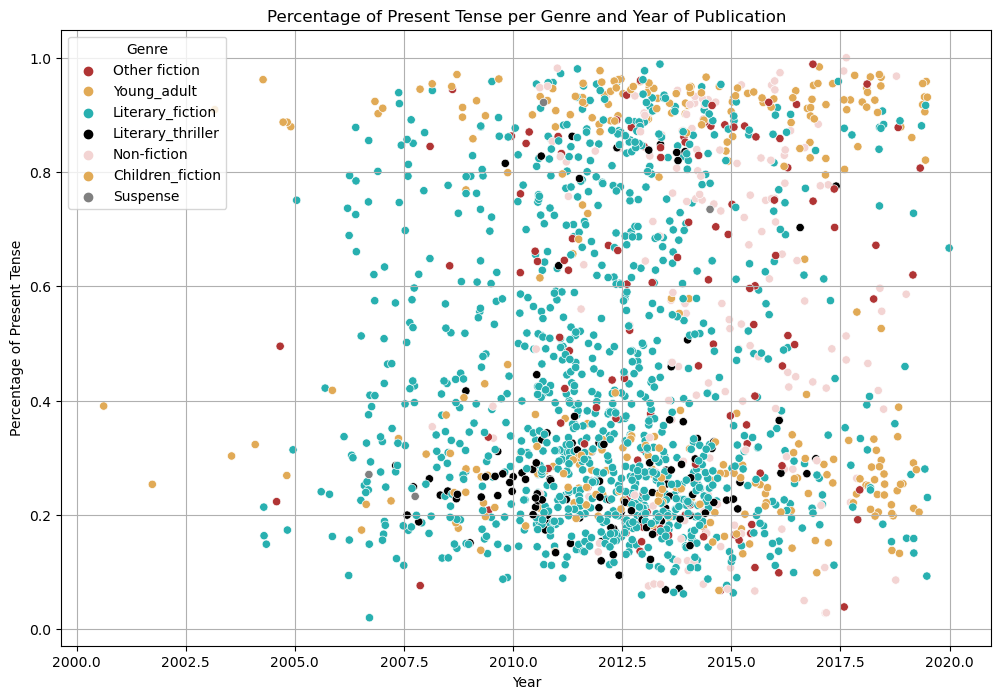

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import random

def jitter(limit):
    return lambda x: random.uniform(-limit, limit) + x
custom_palette = ["#b03434", "#E1AA56", "#28b0b0", "#000000", "#F3D4D3", "#E1AA56", "gray"]

meta_df1['jittered_work_year'] = meta_df1['work_year'].apply(jitter(0.5))

plt.figure(figsize=(12, 8))
sns.scatterplot(data=meta_df1, x='jittered_work_year', y='pv_present_ratio', hue='nur_genre', palette=custom_palette)

plt.title('Percentage of Present Tense per Genre and Year of Publication')
plt.xlabel('Year')
plt.ylabel('Percentage of Present Tense')
plt.legend(title='Genre', loc='upper left')
plt.grid(True)

plt.show()

It seems that there is a group of books which are majorily written in present tense (above on the plot). Since  more than the half of the books in our dataset are literary fiction, we can make a clearer plot with only literary fiction:

/var/folders/yd/6g96kml5407d0k10ztk2lgxnsmsx4t/T/ipykernel_14591/4014508960.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  literary_fiction_df['jittered_work_year'] = literary_fiction_df['work_year'].apply(jitter(0.5))


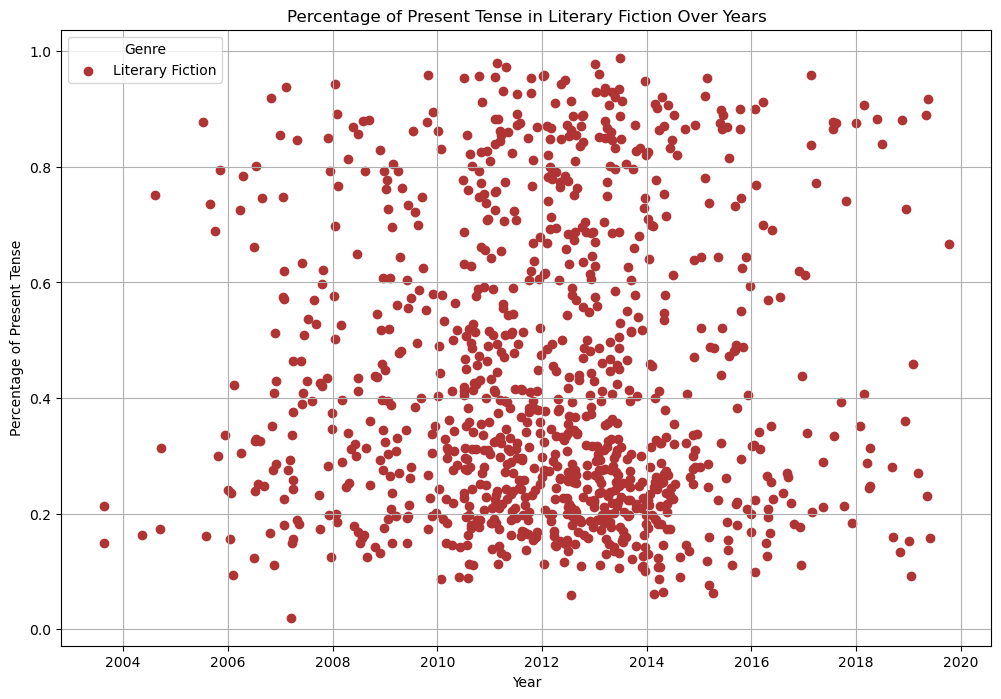

In [27]:
literary_fiction_df = meta_df1[meta_df1['nur_genre'] == "Literary_fiction"]

# Voeg jitter toe aan 'work_year'
literary_fiction_df['jittered_work_year'] = literary_fiction_df['work_year'].apply(jitter(0.5))

# Maak de plot
plt.figure(figsize=(12, 8))
plt.scatter(
    literary_fiction_df['jittered_work_year'],
    literary_fiction_df['pv_present_ratio'],
    color="#b03434",  # Specifieke kleur voor deze categorie
    label="Literary Fiction"
)

# Voeg labels en stijlen toe
plt.title('Percentage of Present Tense in Literary Fiction Over Years')
plt.xlabel('Year')
plt.ylabel('Percentage of Present Tense')
plt.legend(title='Genre', loc='upper left')
plt.grid(True)

# Toon de plot
plt.show()

### Kendall-tau test

We then concuct a Kendall-tau test to see if there is any correlation between the year of publication and the percentage of present tence literature:

In [28]:
from scipy.stats import kendalltau

literary_fiction_df = meta_df1[meta_df1['nur_genre'] == "Literary_fiction"]

years = literary_fiction_df['work_year']
percent_present_tense = literary_fiction_df['pv_present_ratio']

tau, p_value = kendalltau(years, percent_present_tense)

print(f"Kendall's Tau: {tau}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a significant relationship between the year of publication and the percentage of present tense.")
else:
    print("No significant relationship was found.")

Kendall's Tau: -0.02788793855217469
P-value: 0.20749469366518114
No significant relationship was found.


### Let's try also Pearson correlation

check for linearity

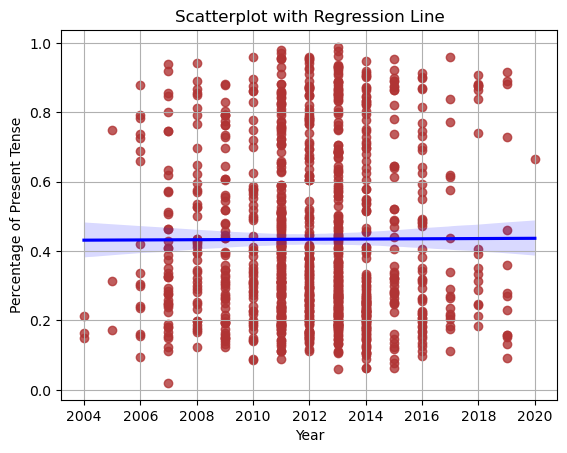

In [29]:
import seaborn as sns

sns.regplot(
    x='work_year', 
    y='pv_present_ratio', 
    data=literary_fiction_df, 
    scatter_kws={'color': '#b03434'}, 
    line_kws={'color': 'blue'}
)
plt.title('Scatterplot with Regression Line')
plt.xlabel('Year')
plt.ylabel('Percentage of Present Tense')
plt.grid(True)
plt.show()

check normality

In [30]:
from scipy.stats import shapiro

# Check normality for pv_present_ratio
stat, p = shapiro(literary_fiction_df['pv_present_ratio'])
print(f"Shapiro-Wilk Test p-value for Present Tense: {p}")

# Check normality for work_year
stat, p = shapiro(literary_fiction_df['work_year'])
print(f"Shapiro-Wilk Test p-value for Year: {p}")

Shapiro-Wilk Test p-value for Present Tense: 4.352973129193899e-24
Shapiro-Wilk Test p-value for Year: 2.394691910045932e-11


now the test itself:

In [31]:
literary_fiction_df = literary_fiction_df.dropna(subset=['work_year', 'pv_present_ratio'])
literary_fiction_df = literary_fiction_df[
    ~literary_fiction_df['work_year'].isin([float('inf'), float('-inf')]) &
    ~literary_fiction_df['pv_present_ratio'].isin([float('inf'), float('-inf')])
]

In [32]:
from scipy.stats import pearsonr

corr, p_value = pearsonr(literary_fiction_df['work_year'], literary_fiction_df['pv_present_ratio'])

print(f"Pearson Correlation Coefficient: {corr}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Significant linear relationship exists between year and present tense usage.")
else:
    print("No significant linear relationship exists between year and present tense usage.")

Pearson Correlation Coefficient: 0.0036337967436494735
P-value: 0.9080386460442763
No significant linear relationship exists between year and present tense usage.


## Bar plot Present tense ratio

We move again to the full dataset (also containing books of which we have no year, and we are looking how they are distributed in terms of present-tense percentages)

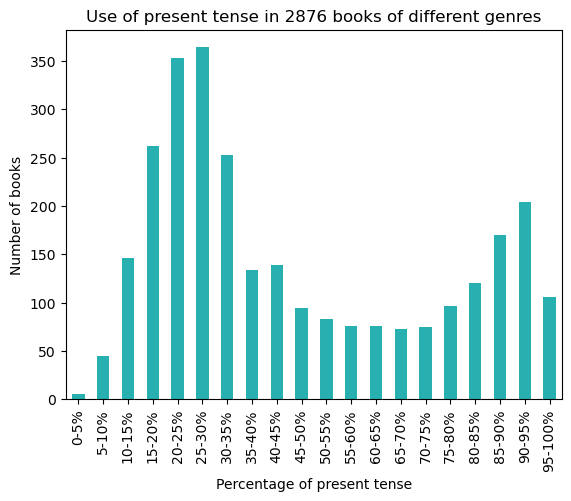

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

present_ratio = meta_df['pv_present_ratio']*100

bin_edges = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

categories = pd.cut(present_ratio, bins=bin_edges, labels=[f'{i}-{i+5}%' for i in range(0, 100, 5)])

summary_df = pd.DataFrame({'Percentage': present_ratio, 'Category': categories})

summary_df.groupby('Category').size().plot(kind='bar', title='Use of present tense in 2876 books of different genres', color='#28b0b0')
plt.xlabel('Percentage of present tense')
plt.ylabel('Number of books')
plt.show()

Let's do the same for only Literary fiction.

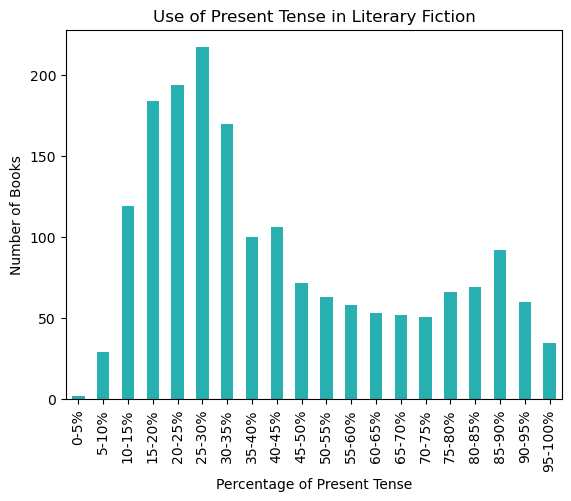

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

literary_fiction_df = meta_df[meta_df['nur_genre'] == "Literary_fiction"]

present_ratio = literary_fiction_df['pv_present_ratio'] * 100
bin_edges = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

categories = pd.cut(present_ratio, bins=bin_edges, labels=[f'{i}-{i+5}%' for i in range(0, 100, 5)])

summary_df = pd.DataFrame({'Percentage': present_ratio, 'Category': categories})

summary_df.groupby('Category').size().plot(
    kind='bar',
    title='Use of Present Tense in Literary Fiction',
    color='#28b0b0'
)

plt.xlabel('Percentage of Present Tense')
plt.ylabel('Number of Books')
plt.show()


## Percentage of present tense per genre

Let's see if the percentage of present tense narrative differs per genre in our dataset.

In [35]:
genre_df = meta_df.loc[:,['work_year', 'nur_genre', 'isbn', 'pv_present_ratio']]

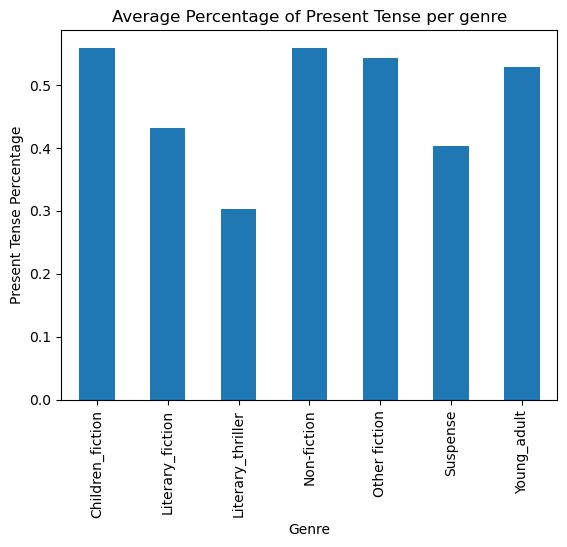

In [36]:
genre_means = genre_df.groupby('nur_genre')['pv_present_ratio'].mean()
genre_means.plot(kind = 'bar', title = "Average Percentage of Present Tense per genre")
plt.xlabel('Genre')
plt.ylabel('Present Tense Percentage')
plt.show()

We can also look at KDE plots showing the distribution of the present-tense usage percentages (pv_present_ratio) across the genres. Each line represents the probability density function of the pv_present_ratio for a specific genre, smoothed to highlight trends.

## KDE plot Distribution of Present Ratios by Genre

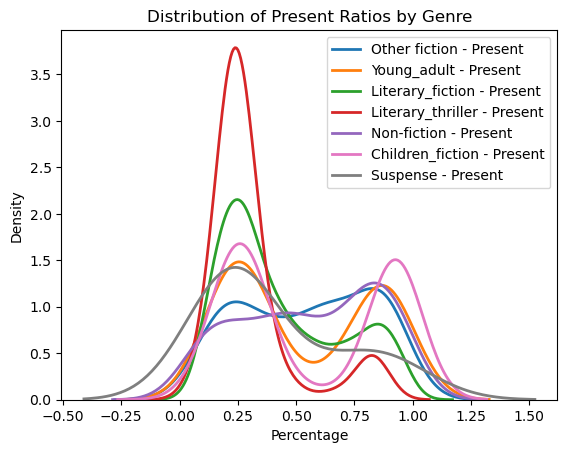

In [37]:
import seaborn as sns
present = meta_df['pv_present_ratio']
past = meta_df['pv_past_ratio']

genres = meta_df['nur_genre'].unique()
for g in genres:
    subset = meta_df[meta_df['nur_genre'] == g]
    sns.kdeplot(subset['pv_present_ratio'], label=f'{g} - Present', linewidth=2)

plt.title('Distribution of Present Ratios by Genre')
plt.xlabel('Percentage')
plt.ylabel('Density')
plt.legend()
plt.show()

This is a beautiful plot, but let's also check with ANOVA if the use of present tense can be seen as genre dependant. The dependent variable (pv_present_ratio) is continuous. bThe independent variable (nur_genre) is categorical (genres in this case).

In [38]:
print(meta_df.groupby('nur_genre')['pv_present_ratio'].count())

nur_genre
Children_fiction      238
Literary_fiction     1792
Literary_thriller     128
Non-fiction           161
Other fiction         122
Suspense                7
Young_adult            85
Name: pv_present_ratio, dtype: int64


In [39]:
genres_with_data = meta_df.groupby('nur_genre')['pv_present_ratio'].count()
valid_genres = genres_with_data[genres_with_data > 0].index
filtered_df = meta_df[meta_df['nur_genre'].isin(valid_genres)]

In [40]:
from scipy.stats import f_oneway

anova_stat, p_anova = f_oneway(
    *[filtered_df[filtered_df['nur_genre'] == genre]['pv_present_ratio'] for genre in valid_genres]
)

print(f"ANOVA p-value: {p_anova}")

if p_anova < 0.05:
    print("Significant differences exist between genres.")
else:
    print("No significant differences found between genres.")


ANOVA p-value: 2.765307378948952e-26
Significant differences exist between genres.


## Categories based on tense used

In [41]:
def categorize_books(row):
    if row['pv_present_ratio'] >= 0.7:
        return "present"
    elif row['pv_past_ratio'] >= 0.7:
        return "past"
    else:
        return "mix"

meta_df['category'] = meta_df.apply(categorize_books, axis=1)

In [42]:
meta_df['category'].value_counts()

past       1176
mix         928
present     772
Name: category, dtype: int64

## TTR

In [43]:
meta_df['ttr']= meta_df['unique_tokens_count']/meta_df['num_tokens']

In [44]:
meta_df['ttr']

0       0.100553
1       0.094808
2       0.335867
3       0.172417
4       0.078390
          ...   
2871    0.169960
2872    0.103831
2873    0.235682
2874    0.094419
2875    0.082426
Name: ttr, Length: 2876, dtype: float64

## Reviews (number per book)

In [45]:
tsv_file = '/Users/katjat/Desktop/Research/Present_tense_fiction/work_isbn_num_reviews.tsv' 
tsv_df = pd.read_csv(tsv_file, sep='\t')

num_reviews_df = tsv_df[['isbn', 'num_reviews']]

meta_df = meta_df.merge(num_reviews_df, on='isbn', how='left')

meta_df.T

,0,1,2,3,4,5,6,7,8,9,...,2866,2867,2868,2869,2870,2871,2872,2873,2874,2875
record_id,9789044623550,9789021449760,9789029590280,9789044626674,9789021441955,9789035142718,9789021454689,NaN,9789025863524,9789025870133,...,9789029505680,9789038899732,9789025875862,9789038891309,NaN,9789025367572,9789021446561,9789044626865,9789021441320,9789021436272
record_id_type,isbn,isbn,isbn,isbn,isbn,isbn,isbn,NaN,isbn,isbn,...,isbn,isbn,isbn,isbn,NaN,isbn,isbn,isbn,isbn,isbn
work_year,2013.0,2014.0,NaN,2014.0,2012.0,2014.0,2014.0,NaN,NaN,2015.0,...,2016.0,2014.0,2018.0,2009.0,NaN,2010.0,2013.0,2014.0,2011.0,2009.0
nur,['320'],"['285', '333']",['301'],['301'],['305'],['700'],"['340', '285']",NaN,['301'],['283'],...,['301'],['301'],['282'],['301'],NaN,['302'],['305'],['302'],['305'],['301']
nur_genre,Other fiction,Young_adult,Literary_fiction,Literary_fiction,Literary_thriller,Non-fiction,Young_adult,NaN,Literary_fiction,Children_fiction,...,Literary_fiction,Literary_fiction,Children_fiction,Literary_fiction,NaN,Literary_fiction,Literary_thriller,Literary_fiction,Literary_thriller,Literary_fiction
isbn,9789044623550,9789021449760,9789029590280,9789044626674,9789021441955,9789035142718,9789021454689,9789021677132,9789025863524,9789025870133,...,9789029505680,9789038899732,9789025875862,9789038891309,9789021668703,9789025367572,9789021446561,9789044626865,9789021441320,9789021436272
total_verbs,8142,17396,347,6145,11539,3942,13532,3386,4378,10299,...,11803,7664,4380,5166,3101,2884,10610,1026,11301,4273
present_verbs,3982,1813,124,709,1731,1940,1910,549,630,1768,...,2270,1457,881,2344,818,1328,963,149,1468,494
past_verbs,733,8294,97,2097,4946,154,6438,1888,1695,5003,...,4855,3491,2364,570,1154,447,4839,452,4926,2834
pv_verbs,4721,10112,221,2808,6679,2099,8350,2438,2328,6772,...,7134,4948,3245,2917,1973,1775,5804,601,6396,3328


## Book counts per category

In [46]:
book_counts = meta_df[meta_df['nur_genre'] == 'Literary_fiction']['category'].value_counts()
book_counts

past       745
mix        674
present    373
Name: category, dtype: int64

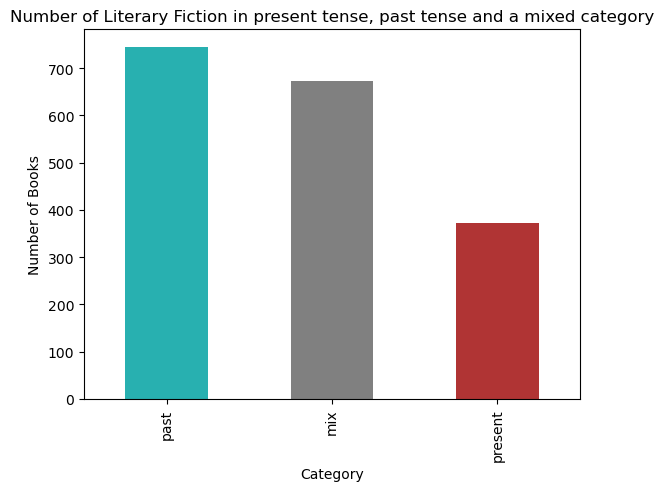

In [47]:
book_counts = meta_df[meta_df['nur_genre'] == 'Literary_fiction']['category'].value_counts()
book_counts.plot(kind='bar', color=['#28b0b0', 'grey', '#b03434'])
plt.title('Number of Literary Fiction in present tense, past tense and a mixed category')
plt.xlabel('Category')
plt.ylabel('Number of Books')
plt.show()

#### Number of words per category

In [48]:
num_tokens_present = meta_df.loc[(meta_df['category'] == 'present') & (meta_df['nur_genre'] == 'Literary_fiction'), 'num_tokens'].sum()
num_tokens_past = meta_df.loc[(meta_df['category'] == 'past') & (meta_df['nur_genre'] == 'Literary_fiction'), 'num_tokens'].sum()
num_tokens_mix = meta_df.loc[(meta_df['category'] == 'mix') & (meta_df['nur_genre'] == 'Literary_fiction'), 'num_tokens'].sum()

print("No. of words in category 'present':", num_tokens_present)
print("No. of words in category 'past':", num_tokens_past)
print("No. of words in category 'mix':", num_tokens_mix)

No. of words in category 'present': 23191181
No. of words in category 'past': 53279335
No. of words in category 'mix': 48981695


### Average counts

#### Average sentence length

In [49]:
average_sentence_length_present = meta_df.loc[(meta_df['category'] == 'present') & (meta_df['nur_genre'] == 'Literary_fiction'), 'sent_len_mean'].mean()
average_sentence_length_past = meta_df.loc[(meta_df['category'] == 'past') & (meta_df['nur_genre'] == 'Literary_fiction'), 'sent_len_mean'].mean()
average_sentence_length_mix = meta_df.loc[(meta_df['category'] == 'mix') & (meta_df['nur_genre'] == 'Literary_fiction'), 'sent_len_mean'].mean()

print("Average Sentence Length for Books in 'present' category:", average_sentence_length_present)
print("Average Sentence Length for Books in 'past' category:", average_sentence_length_past)
print("Average Sentence Length for Books in 'mix' category:", average_sentence_length_mix)

Average Sentence Length for Books in 'present' category: 16.061939845841554
Average Sentence Length for Books in 'past' category: 16.36226206380255
Average Sentence Length for Books in 'mix' category: 15.956719923995426


#### Average number of words

In [50]:
av_num_tokens_present = meta_df.loc[(meta_df['category'] == 'present') & (meta_df['nur_genre'] == 'Literary_fiction'), 'num_tokens'].mean()
av_num_tokens_past = meta_df.loc[(meta_df['category'] == 'past') & (meta_df['nur_genre'] == 'Literary_fiction'), 'num_tokens'].mean()
av_num_tokens_mix = meta_df.loc[(meta_df['category'] == 'mix') & (meta_df['nur_genre'] == 'Literary_fiction'), 'num_tokens'].mean()

print("Average number of words in category 'present':", av_num_tokens_present)
print("Average number of words in category 'past':", av_num_tokens_past)
print("Average number of words in category 'mix':", av_num_tokens_mix)

Average number of words in category 'present': 62174.74798927614
Average number of words in category 'past': 71515.88590604028
Average number of words in category 'mix': 72673.13798219584


#### TTR per category

In [51]:
ttr_mean_present = meta_df.loc[(meta_df['category'] == 'present') & (meta_df['nur_genre'] == 'Literary_fiction'), 'ttr'].mean()
ttr_mean_past = meta_df.loc[(meta_df['category'] == 'past') & (meta_df['nur_genre'] == 'Literary_fiction'), 'ttr'].mean()
ttr_mean_mix = meta_df.loc[(meta_df['category'] == 'mix') & (meta_df['nur_genre'] == 'Literary_fiction'), 'ttr'].mean()

print("TTR for Books in 'present' category:", ttr_mean_present)
print("TTR for Books in 'past' category:", ttr_mean_past)
print("TTR for Books in 'mix' category:", ttr_mean_mix)

TTR for Books in 'present' category: 0.14915862645290234
TTR for Books in 'past' category: 0.1433840783715997
TTR for Books in 'mix' category: 0.14547011845854166


## Literary_fiction per category and reader response

Let's look into different categories of literary books. Is there a difference in amount of online book reviews as responce on different categories of books in terms of tense use?

In [52]:
literary_books_stats = meta_df[meta_df['nur_genre'] == 'Literary_fiction']
literary_books_stats.T

,2,3,8,10,11,15,16,17,18,19,...,2862,2863,2864,2865,2866,2867,2869,2871,2873,2875
record_id,9789029590280,9789044626674,9789025863524,9789029587495,9789029581134,9789025365295,9789038897288,9789029591997,9789021444888,9789038896168,...,9789038897035,9789029569507,9789021418186,9789038895550,9789029505680,9789038899732,9789038891309,9789025367572,9789044626865,9789021436272
record_id_type,isbn,isbn,isbn,isbn,isbn,isbn,isbn,isbn,isbn,isbn,...,isbn,isbn,isbn,isbn,isbn,isbn,isbn,isbn,isbn,isbn
work_year,NaN,2014.0,NaN,2013.0,NaN,2007.0,NaN,NaN,2013.0,NaN,...,NaN,2006.0,2019.0,NaN,2016.0,2014.0,2009.0,2010.0,2014.0,2009.0
nur,['301'],['301'],['301'],['302'],['301'],['302'],['301'],['301'],['301'],['301'],...,['301'],['300'],['301'],['301'],['301'],['301'],['301'],['302'],['302'],['301']
nur_genre,Literary_fiction,Literary_fiction,Literary_fiction,Literary_fiction,Literary_fiction,Literary_fiction,Literary_fiction,Literary_fiction,Literary_fiction,Literary_fiction,...,Literary_fiction,Literary_fiction,Literary_fiction,Literary_fiction,Literary_fiction,Literary_fiction,Literary_fiction,Literary_fiction,Literary_fiction,Literary_fiction
isbn,9789029590280,9789044626674,9789025863524,9789029587495,9789029581134,9789025365295,9789038897288,9789029591997,9789021444888,9789038896168,...,9789038897035,9789029569507,9789021418186,9789038895550,9789029505680,9789038899732,9789038891309,9789025367572,9789044626865,9789021436272
total_verbs,347,6145,4378,11879,4891,28532,4938,827,32966,9970,...,13987,12400,4448,2601,11803,7664,5166,2884,1026,4273
present_verbs,124,709,630,4490,1017,4817,291,158,2666,1678,...,1179,4450,337,762,2270,1457,2344,1328,149,494
past_verbs,97,2097,1695,2063,2327,9854,2251,346,15482,4953,...,8102,2287,1788,909,4855,3491,570,447,452,2834
pv_verbs,221,2808,2328,6561,3347,14678,2544,504,18440,6631,...,9284,6750,2126,1672,7134,4948,2917,1775,601,3328


In [53]:
literary_books_stats.groupby('category')['num_reviews'].sum()

category
mix        7683.0
past       8397.0
present    6455.0
Name: num_reviews, dtype: float64

In [54]:
literary_books_stats.groupby('category')['num_reviews'].mean()

category
mix        11.399110
past       11.271141
present    17.305630
Name: num_reviews, dtype: float64

### Plot for the mean/sum of the number of reviews

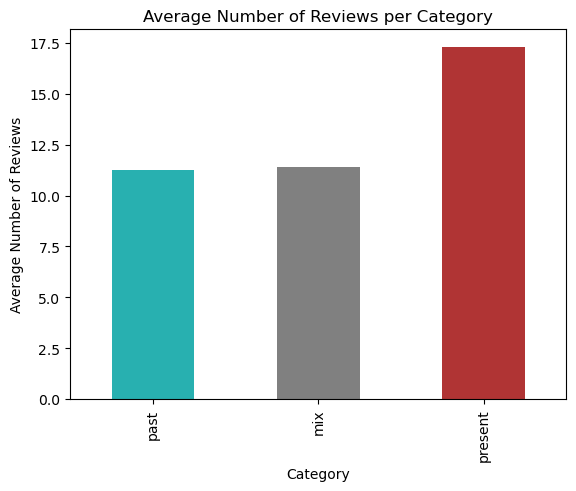

In [55]:
import matplotlib.pyplot as plt

average_reviews_by_category = literary_books_stats.groupby('category')['num_reviews'].mean()

category_order = ['past', 'mix', 'present']

colors = {'past': '#28b0b0', 'mix': 'grey', 'present': '#b03434'}

average_reviews_by_category.loc[category_order].plot(kind='bar', color=[colors[cat] for cat in category_order])

plt.title('Average Number of Reviews per Category')
plt.xlabel('Category')
plt.ylabel('Average Number of Reviews')
plt.show()

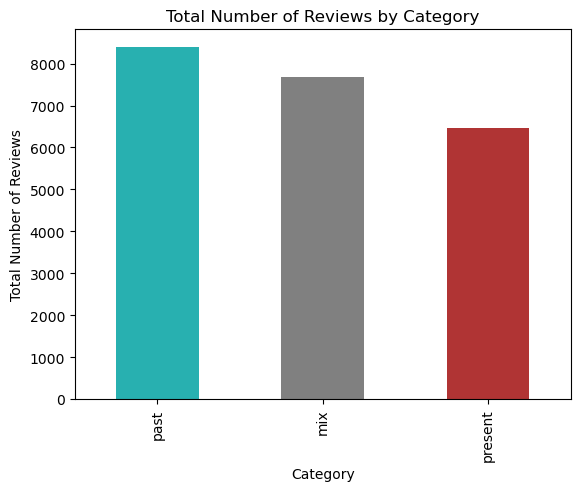

In [56]:
import matplotlib.pyplot as plt

review_sum_by_category = literary_books_stats.groupby('category')['num_reviews'].sum()

category_order = ['past', 'mix', 'present']

colors = {'past': '#28b0b0', 'mix': 'grey', 'present': '#b03434'}

review_sum_by_category.loc[category_order].plot(kind='bar', color=[colors[cat] for cat in category_order])

plt.title('Total Number of Reviews by Category')
plt.xlabel('Category')
plt.ylabel('Total Number of Reviews')
plt.show()

### Permutation test for the number of reviews

In [57]:
import numpy as np

def calculate_reviews_test_statistic(df1, df2):
    return np.abs(df1['num_reviews'].mean() - df2['num_reviews'].mean())

observed_reviews_statistic = calculate_reviews_test_statistic(
    literary_books_stats[literary_books_stats['category'] == 'present'],
    literary_books_stats[literary_books_stats['category'] == 'past']
)

combined_reviews = pd.concat([
    literary_books_stats[literary_books_stats['category'] == 'present'],
    literary_books_stats[literary_books_stats['category'] == 'past']
], ignore_index=True)

num_permutations = 1000
permuted_reviews_statistics = np.zeros(num_permutations)

np.random.seed(123)
for i in range(num_permutations):
    np.random.shuffle(combined_reviews['num_reviews'].values)

    permuted_reviews_statistics[i] = calculate_reviews_test_statistic(
        combined_reviews[combined_reviews['category'] == 'present'],
        combined_reviews[combined_reviews['category'] == 'past']
    )

p_value_reviews = np.mean(permuted_reviews_statistics >= observed_reviews_statistic)

print("Observed Reviews Test Statistic:", observed_reviews_statistic)
print("Permutation Test p-value for Reviews:", p_value_reviews)

Observed Reviews Test Statistic: 6.034489087212338
Permutation Test p-value for Reviews: 0.012


The fact that there are significantly more reviews for present tense literature is very interesting, it is than important to look at the features of these teksts. We know already, that there is no differense in sentence length, average number of words and TTR, but we can look at parts of speech. We will do that for all books in the dataset and for literary fiction apart.

# Textual features (POS) - regression analysis

## Make groups of books in present, past and mixed tense categories (only for Literary fiction)

In [58]:
present_df = meta_df[meta_df['category'] == 'present']
past_df = meta_df[meta_df['category'] == 'past']
mix_df = meta_df[meta_df['category'] == 'mix']

print(f"Number of books in present tense: {len(present_df)}")
print(f"Number of books in past tense: {len(past_df)}")
print(f"Number of books in mixed tense: {len(mix_df)}")

Number of books in present tense: 772
Number of books in past tense: 1176
Number of books in mixed tense: 928


In [59]:
literary_fiction_df = meta_df[meta_df['nur_genre'] == 'Literary_fiction']

present_lf_df = literary_fiction_df[literary_fiction_df['category'] == 'present']
past_lf_df = literary_fiction_df[literary_fiction_df['category'] == 'past']
mix_lf_df = literary_fiction_df[literary_fiction_df['category'] == 'mix']

print(f"Number of books in present tense (literary fiction): {len(present_lf_df)}")
print(f"Number of books in past tense (literary fiction): {len(past_lf_df)}")
print(f"Number of books in mixed tense (literary fiction): {len(mix_lf_df)}")

Number of books in present tense (literary fiction): 373
Number of books in past tense (literary fiction): 745
Number of books in mixed tense (literary fiction): 674


It is obvious, that num_tokens and unique_token_count are responsible for collinearity, so we can try this:

1. Regression without num_tokens and unique_token_count
2. Lasso Regression with all the components

### OSL Regression without num_tokens and unique_token_count

In [73]:
import statsmodels.api as sm

# Define predictors and dependent variable
predictors = ['total_verbs', 'pron_count', 'propn_count', 'noun_count', 
              'adj_count', 'adv_count', 'sconj_count', 'cconj_count', 'punct_count']
dependent = 'present_ratio'

# Function to run simple regression
def run_simple_regression(df, predictors, dependent):
    X = df[predictors]
    y = df[dependent]
    X = sm.add_constant(X)  # Add intercept
    model = sm.OLS(y, X).fit()
    return model

# Regression for all genres (meta_df)
meta_model = run_simple_regression(meta_df, predictors, dependent)
print("Regression Results for All Genres (meta_df):")
print(meta_model.summary())

# Regression for literary fiction (literary_fiction_df)
literary_model = run_simple_regression(literary_fiction_df, predictors, dependent)
print("\nRegression Results for Literary Fiction (literary_fiction_df):")
print(literary_model.summary())


Regression Results for All Genres (meta_df):
                            OLS Regression Results                            
Dep. Variable:          present_ratio   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     22.02
Date:                Wed, 18 Dec 2024   Prob (F-statistic):           1.68e-36
Time:                        15:15:30   Log-Likelihood:                 866.46
No. Observations:                2876   AIC:                            -1713.
Df Residuals:                    2866   BIC:                            -1653.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const

/var/folders/yd/6g96kml5407d0k10ztk2lgxnsmsx4t/T/ipykernel_14591/2062025423.py:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=results_df, x="Coefficient", y="Predictor", color="skyblue", ci=None)


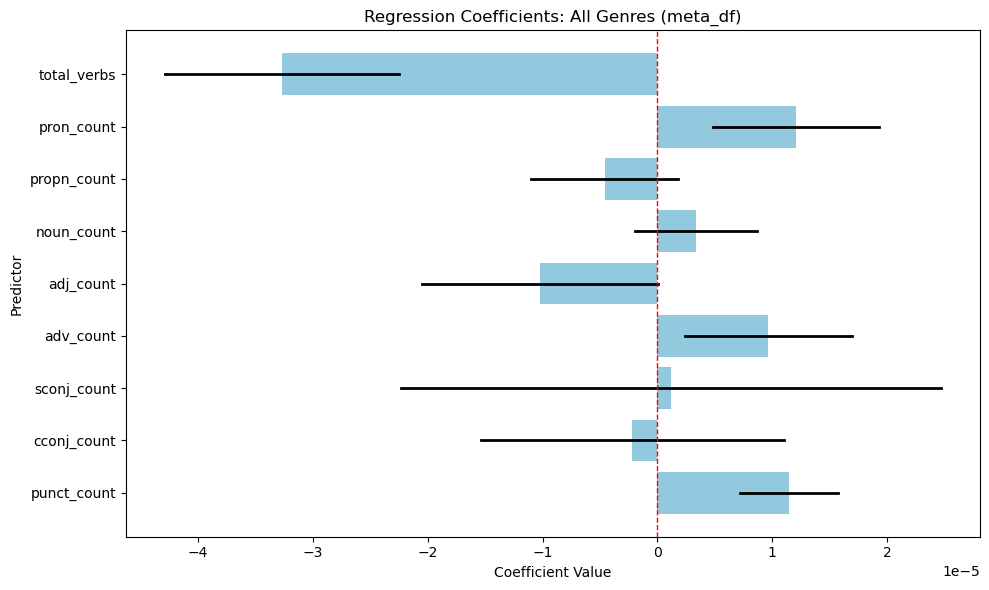

/var/folders/yd/6g96kml5407d0k10ztk2lgxnsmsx4t/T/ipykernel_14591/2062025423.py:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=results_df, x="Coefficient", y="Predictor", color="skyblue", ci=None)


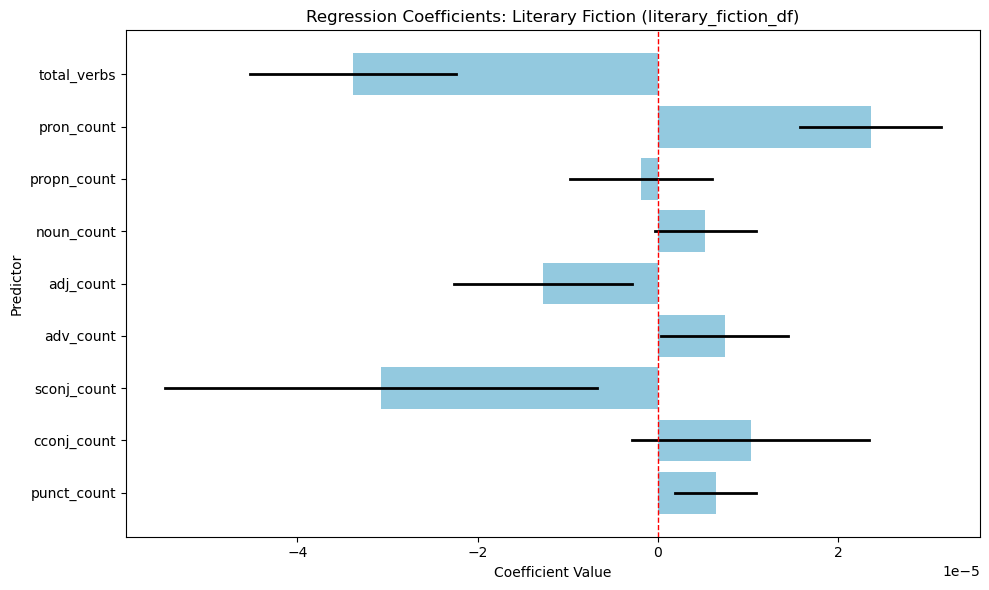

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example results for meta_df and literary_fiction_df
meta_results = {
    "Predictor": ['total_verbs', 'pron_count', 'propn_count', 'noun_count',
                  'adj_count', 'adv_count', 'sconj_count', 'cconj_count', 'punct_count'],
    "Coefficient": [-3.271e-5, 1.205e-5, -4.611e-6, 3.365e-6, -1.02e-5, 9.642e-6, 1.2e-6, -2.23e-6, 1.144e-5],
    "Lower CI": [-4.29e-5, 4.81e-6, -1.1e-5, -1.93e-6, -2.05e-5, 2.42e-6, -2.23e-5, -1.54e-5, 7.19e-6],
    "Upper CI": [-2.25e-5, 1.93e-5, 1.77e-6, 8.67e-6, 6.79e-8, 1.69e-5, 2.47e-5, 1.1e-5, 1.57e-5]
}

literary_results = {
    "Predictor": ['total_verbs', 'pron_count', 'propn_count', 'noun_count',
                  'adj_count', 'adv_count', 'sconj_count', 'cconj_count', 'punct_count'],
    "Coefficient": [-3.379e-5, 2.36e-5, -1.881e-6, 5.246e-6, -1.278e-5, 7.408e-6, -3.073e-5, 1.026e-5, 6.394e-6],
    "Lower CI": [-4.52e-5, 1.58e-5, -9.72e-6, -3.86e-7, -2.26e-5, 3.71e-7, -5.47e-5, -2.84e-6, 1.89e-6],
    "Upper CI": [-2.24e-5, 3.14e-5, 5.96e-6, 1.09e-5, -2.92e-6, 1.44e-5, -6.79e-6, 2.34e-5, 1.09e-5]
}

# Convert to DataFrames
meta_df_results = pd.DataFrame(meta_results)
literary_df_results = pd.DataFrame(literary_results)

# Visualization function
def plot_coefficients(results_df, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=results_df, x="Coefficient", y="Predictor", color="skyblue", ci=None)
    for index, row in results_df.iterrows():
        plt.plot([row["Lower CI"], row["Upper CI"]], [index, index], "k-", lw=2)
    plt.axvline(0, color="red", linestyle="--", linewidth=1)
    plt.title(title)
    plt.xlabel("Coefficient Value")
    plt.ylabel("Predictor")
    plt.tight_layout()
    plt.show()

# Plot for All Genres
plot_coefficients(meta_df_results, "Regression Coefficients: All Genres (meta_df)")

# Plot for Literary Fiction
plot_coefficients(literary_df_results, "Regression Coefficients: Literary Fiction (literary_fiction_df)")

Two datasets were analyzed: a mixed-genre corpus (meta_df) and a literary fiction subset (literary_fiction_df). The dependent variable, present_ratio, represents the proportion of present-tense verbs in each text. Nine predictors were included: total_verbs, pron_count, propn_count, noun_count, adj_count, adv_count, sconj_count, cconj_count, and punct_count. Ordinary least squares (OLS) regression was used to model the relationships between these predictors and present_ratio. Separate models were fitted for the two datasets to facilitate comparison.

Genre-Specific Trends

While total_verbs, pron_count, adv_count, and punct_count were significant in both models, the effects of adj_count and sconj_count were specific to literary fiction. These findings suggest that stylistic preferences in literary fiction may influence tense usage, with a greater emphasis on descriptive and subordinating structures linked to non-present-tense contexts.

Discussion
The results reveal both universal and genre-specific predictors of present_ratio. Universally, pron_count and adv_count positively influence present-tense usage, highlighting their role in immediate and direct expression. Conversely, total_verbs consistently reduce present_ratio, likely reflecting narrative complexity and temporal depth.

In literary fiction, the unique effects of adj_count and sconj_count suggest that stylistic conventions prioritize descriptive richness and complex clause structures, often associated with past or future tenses. These findings align with previous studies on the stylistic distinctiveness of literary fiction, emphasizing the interplay between linguistic features and narrative perspective.

Conclusion
This study identifies key linguistic predictors of present-tense usage and highlights their variation across genres. The findings underscore the importance of considering genre-specific stylistic norms in linguistic analyses and contribute to our understanding of how language shapes temporal and narrative dimensions. Future research could extend this approach to other genres and explore additional predictors, such as syntactic complexity and discourse markers, to further elucidate the determinants of tense usage.

Figures

Figure 1: Regression coefficients for all genres (meta_df)

Figure 2: Regression coefficients for literary fiction (literary_fiction_df)

### Lasso regression with all predictors (including num_tokens and unique_token_ratio)

/Users/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028649500470478984, tolerance: 0.007866232581523282
  model = cd_fast.enet_coordinate_descent_gram(
/Users/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19051637202177574, tolerance: 0.007866232581523282
  model = cd_fast.enet_coordinate_descent_gram(
/Users/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2532439685162302, tolerance: 0.007866232581523282
  model = cd_fast.enet_coordinate_descent_gram(
/Users/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_co

Lasso Regression Coefficients:
              Predictor  Coefficient
5            noun_count     0.382975
3            pron_count     0.226302
10          punct_count     0.173538
7             adv_count     0.138825
4           propn_count     0.052523
6             adj_count     0.050737
8           sconj_count     0.018764
9           cconj_count     0.000001
2   unique_tokens_count    -0.083112
1           total_verbs    -0.146623
0            num_tokens    -0.815640


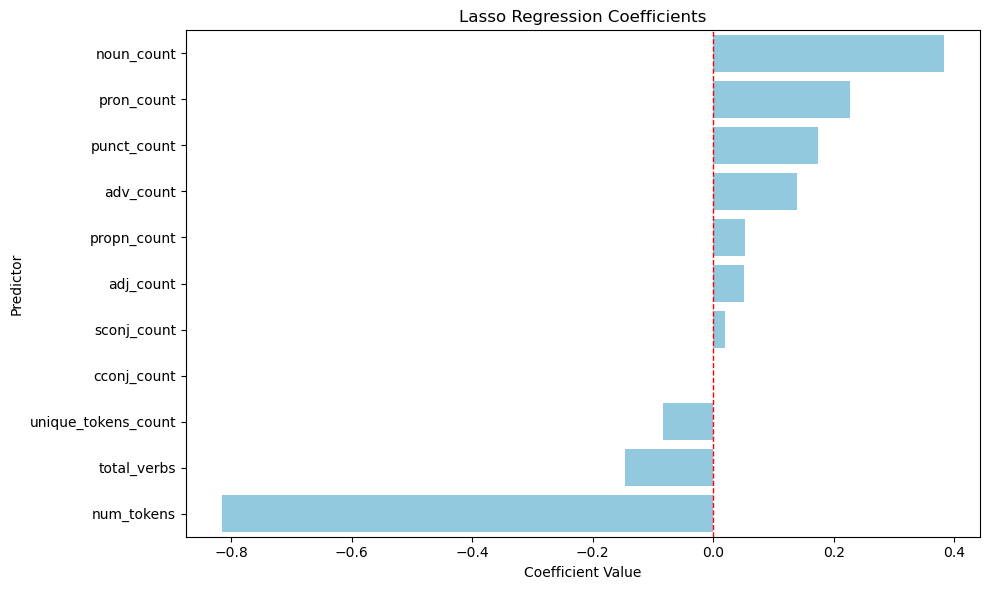

In [75]:
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


predictors_lasso = ['num_tokens', 'total_verbs', 'unique_tokens_count', 'pron_count',
                    'propn_count', 'noun_count', 'adj_count', 'adv_count',
                    'sconj_count', 'cconj_count', 'punct_count']
dependent = 'present_ratio'

X_meta_lasso = meta_df[predictors_lasso]
y_meta_lasso = meta_df[dependent]

lasso_pipeline = make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=42))
lasso_pipeline.fit(X_meta_lasso, y_meta_lasso)

lasso_coefficients = lasso_pipeline.named_steps['lassocv'].coef_
lasso_results = pd.DataFrame({
    "Predictor": predictors_lasso,
    "Coefficient": lasso_coefficients
}).sort_values(by="Coefficient", ascending=False)

print("Lasso Regression Coefficients:")
print(lasso_results)

lasso_results.to_csv("lasso_coefficients.csv", index=False)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=lasso_results, x="Coefficient", y="Predictor", color="skyblue")
plt.axvline(0, color="red", linestyle="--", linewidth=1)
plt.title("Lasso Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Predictor")
plt.tight_layout()
plt.show()


/Users/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07792050893673519, tolerance: 0.0037147345747224722
  model = cd_fast.enet_coordinate_descent_gram(
/Users/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33267735369293305, tolerance: 0.0037147345747224722
  model = cd_fast.enet_coordinate_descent_gram(
/Users/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20676848780735213, tolerance: 0.0037147345747224722
  model = cd_fast.enet_coordinate_descent_gram(
/Users/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/

Lasso Regression Coefficients for Literary Fiction:
              Predictor  Coefficient
3            pron_count     0.255435
5            noun_count     0.221192
10          punct_count     0.112012
7             adv_count     0.094182
9           cconj_count     0.031568
4           propn_count     0.027690
6             adj_count    -0.001701
2   unique_tokens_count    -0.014718
8           sconj_count    -0.021144
1           total_verbs    -0.165594
0            num_tokens    -0.532243


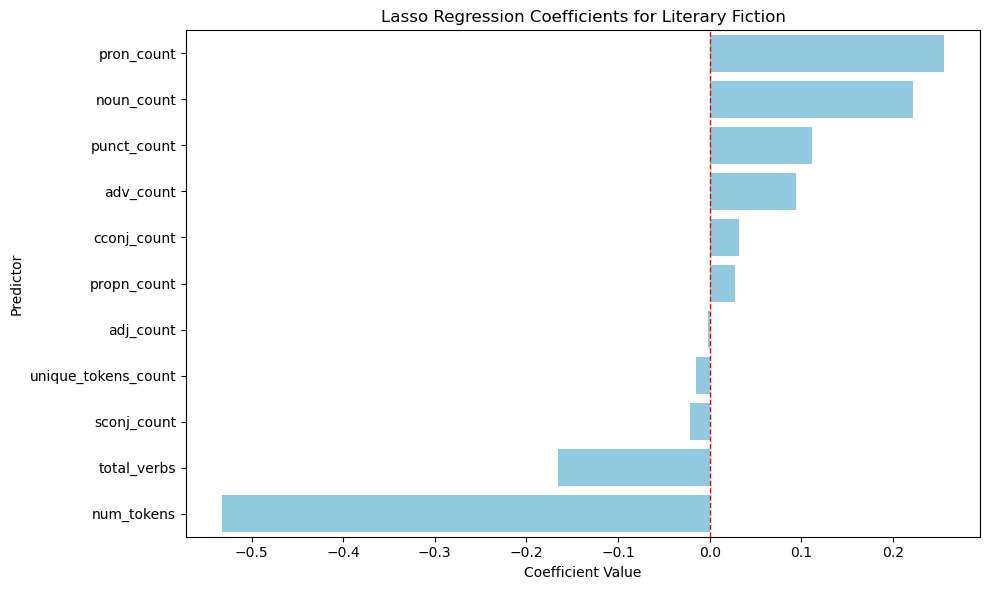

In [76]:
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Define predictors and dependent variable for literary_fiction_df
predictors_lasso = ['num_tokens', 'total_verbs', 'unique_tokens_count', 'pron_count',
                    'propn_count', 'noun_count', 'adj_count', 'adv_count',
                    'sconj_count', 'cconj_count', 'punct_count']
dependent = 'present_ratio'

# Extract features and target from literary_fiction_df
X_literary_lasso = literary_fiction_df[predictors_lasso]
y_literary_lasso = literary_fiction_df[dependent]

# Create and fit Lasso regression with cross-validation
lasso_pipeline = make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=42))
lasso_pipeline.fit(X_literary_lasso, y_literary_lasso)

# Extract coefficients
lasso_coefficients = lasso_pipeline.named_steps['lassocv'].coef_
lasso_results = pd.DataFrame({
    "Predictor": predictors_lasso,
    "Coefficient": lasso_coefficients
}).sort_values(by="Coefficient", ascending=False)

# Display results
print("Lasso Regression Coefficients for Literary Fiction:")
print(lasso_results)

# Save results to a CSV file (optional)
lasso_results.to_csv("lasso_coefficients_literary_fiction.csv", index=False)

# Plot the Lasso coefficients
plt.figure(figsize=(10, 6))
sns.barplot(data=lasso_results, x="Coefficient", y="Predictor", color="skyblue")
plt.axvline(0, color="red", linestyle="--", linewidth=1)
plt.title("Lasso Regression Coefficients for Literary Fiction")
plt.xlabel("Coefficient Value")
plt.ylabel("Predictor")
plt.tight_layout()
plt.show()


Let's look closer on the usage of pronouns in books of different categories.

## The use of the pronouns in books of different categories

In [77]:
# from collections import Counter

# def count_each_pronoun(parsed_isbns, data_dir):
#     all_pronoun_counts = []
    
#     for isbn in parsed_isbns:
#         book_tokens = read_book_tokens(isbn, data_dir)
#         # Filter tokens to keep only pronouns
#         pronouns = [token['text'] for token in book_tokens if token['upos'] == 'PRON']
#         # Count each pronoun
#         pronoun_counts = Counter(pronouns)
#         pronoun_counts['isbn'] = isbn  # Add ISBN for reference
#         all_pronoun_counts.append(pronoun_counts)
    
#     # Convert list of counters to a DataFrame
#     pronoun_df = pd.DataFrame(all_pronoun_counts).fillna(0).set_index('isbn')
#     return pronoun_df

# # Count pronouns for all books
# pronoun_counts_df = count_each_pronoun(test_isbns, data_dir)

# # Merge with meta_df to add category information
# merged_df = meta_df.merge(pronoun_counts_df, on='isbn', how='left')


In [88]:
from collections import defaultdict  # Add this import

# Define pronoun mapping
pronoun_groups = {
    'first_singular': ['ik', 'mij', 'me', 'mijn'],
    'first_plural': ['wij', 'ons', 'onze'],
    'second_singular': ['jij', 'jou', 'je', 'jouw', 'u'],
    'second_plural': ['jullie'],
    'third_singular': ['hij', 'hem', 'haar', 'het', 'zijn', 'haar'],
    'third_plural': ['zij', 'ze', 'hun', 'hen', 'hunne'],
    'demonstrative': ['die', 'dat'] 
}

# Reverse the mapping for quick lookup
pronoun_to_group = {pronoun: group for group, pronouns in pronoun_groups.items() for pronoun in pronouns}

def count_personal_pronouns(parsed_isbns, data_dir):
    all_pronoun_counts = []
    
    for isbn in parsed_isbns:
        book_tokens = read_book_tokens(isbn, data_dir)
        counts = defaultdict(int)  # defaultdict is now defined
        
        for token in book_tokens:
            if token['upos'] == 'PRON':
                # Normalize to lowercase
                pronoun = token['text'].lower()
                # Check if the pronoun belongs to a group
                group = pronoun_to_group.get(pronoun)
                if group:
                    counts[group] += 1
        
        # Add counts for this book to the results
        counts['isbn'] = isbn
        all_pronoun_counts.append(counts)
    
    # Convert to DataFrame
    pronoun_df = pd.DataFrame(all_pronoun_counts).fillna(0)
    return pronoun_df

# Count pronouns for all books
personal_pronoun_counts_df = count_personal_pronouns(test_isbns, data_dir)

# Display the DataFrame
personal_pronoun_counts_df.head()



,first_plural,third_singular,demonstrative,first_singular,third_plural,second_singular,second_plural,isbn
0,261.0,2135,569.0,2296.0,422.0,662.0,56.0,9789044623550
1,274.0,3203,1669.0,6862.0,1212.0,1343.0,122.0,9789021449760
2,8.0,98,34.0,117.0,20.0,29.0,0.0,9789029590280
3,71.0,2387,709.0,176.0,684.0,95.0,1.0,9789044626674
4,29.0,5254,1113.0,1494.0,1232.0,1163.0,24.0,9789021441955


In [89]:
personal_pronoun_counts_df

,first_plural,third_singular,demonstrative,first_singular,third_plural,second_singular,second_plural,isbn
0,261.0,2135,569.0,2296.0,422.0,662.0,56.0,9789044623550
1,274.0,3203,1669.0,6862.0,1212.0,1343.0,122.0,9789021449760
2,8.0,98,34.0,117.0,20.0,29.0,0.0,9789029590280
3,71.0,2387,709.0,176.0,684.0,95.0,1.0,9789044626674
4,29.0,5254,1113.0,1494.0,1232.0,1163.0,24.0,9789021441955
...,...,...,...,...,...,...,...,...
2871,86.0,680,263.0,795.0,308.0,573.0,31.0,9789025367572
2872,38.0,4031,978.0,658.0,1144.0,565.0,24.0,9789021446561
2873,20.0,338,84.0,78.0,225.0,94.0,2.0,9789044626865
2874,73.0,5127,1080.0,834.0,1367.0,744.0,80.0,9789021441320


In [90]:
merged_df = personal_pronoun_counts_df.merge(meta_df[['isbn', 'category']], on='isbn', how='left')

merged_df.head()

,first_plural,third_singular,demonstrative,first_singular,third_plural,second_singular,second_plural,isbn,category
0,261.0,2135,569.0,2296.0,422.0,662.0,56.0,9789044623550,present
1,274.0,3203,1669.0,6862.0,1212.0,1343.0,122.0,9789021449760,past
2,8.0,98,34.0,117.0,20.0,29.0,0.0,9789029590280,mix
3,71.0,2387,709.0,176.0,684.0,95.0,1.0,9789044626674,past
4,29.0,5254,1113.0,1494.0,1232.0,1163.0,24.0,9789021441955,past


Average Pronoun Counts:
          first_singular  third_singular
category                                
mix          1882.287716     2424.101293
past         1436.143707     2992.411565
present      1414.648964     1895.066062

T-Test Results:
First Singular: t-statistic = -0.2326978849601815, p-value = 0.8160308007707983
Third Singular: t-statistic = -10.313928335073975, p-value = 2.606897182648299e-24


<Figure size 1000x500 with 0 Axes>

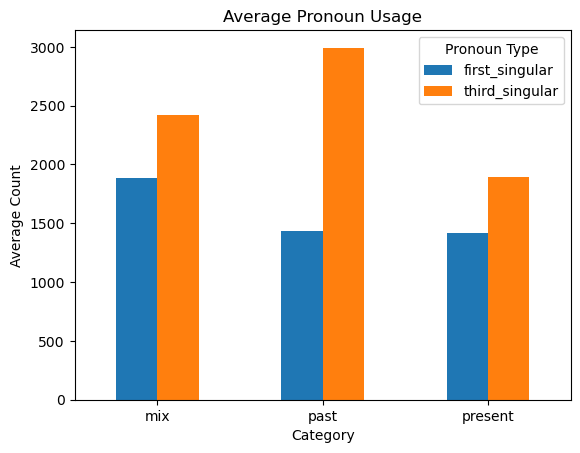

<Figure size 1000x500 with 0 Axes>

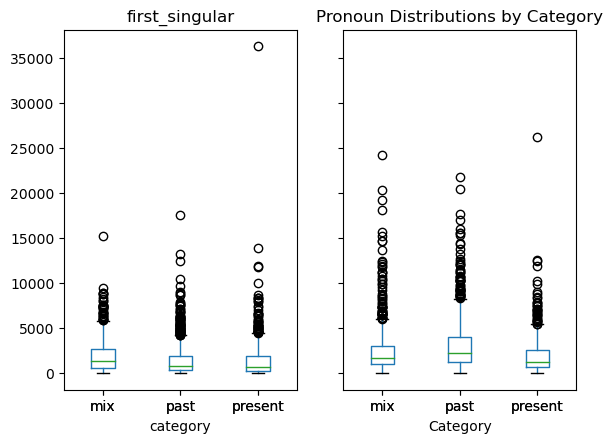

In [93]:
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# Filter for present and past categories
present_df = merged_df[merged_df['category'] == 'present']
past_df = merged_df[merged_df['category'] == 'past']

# Compute average counts
average_counts = merged_df.groupby('category')[['first_singular', 'third_singular']].mean()

# Perform t-tests
t_test_first_singular = ttest_ind(present_df['first_singular'], past_df['first_singular'], equal_var=False)
t_test_third_singular = ttest_ind(present_df['third_singular'], past_df['third_singular'], equal_var=False)

# Print results
print("Average Pronoun Counts:")
print(average_counts)
print("\nT-Test Results:")
print(f"First Singular: t-statistic = {t_test_first_singular.statistic}, p-value = {t_test_first_singular.pvalue}")
print(f"Third Singular: t-statistic = {t_test_third_singular.statistic}, p-value = {t_test_third_singular.pvalue}")

# Visualize differences
plt.figure(figsize=(10, 5))

# Bar plot for averages
average_counts.plot(kind='bar', ylabel='Average Count', xlabel='Category', title='Average Pronoun Usage', rot=0)
plt.legend(title='Pronoun Type')
plt.show()

# Box plots for distributions
plt.figure(figsize=(10, 5))
merged_df.boxplot(column=['first_singular', 'third_singular'], by='category', grid=False)
plt.suptitle('')
plt.title('Pronoun Distributions by Category')
plt.ylabel('Pronoun Count')
plt.xlabel('Category')
plt.show()

First Singular Pronouns:
Observed Difference: -21.494743752423346
P-value: 0.8034

Third Singular Pronouns:
Observed Difference: -1097.3455024496843
P-value: 0.0


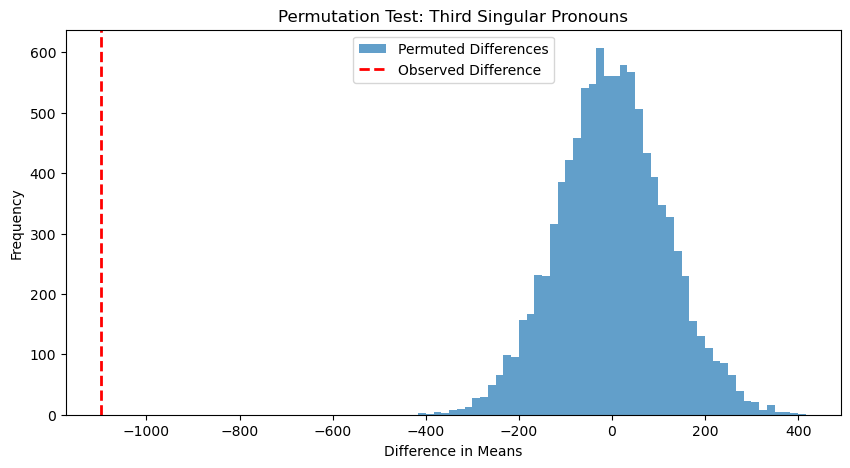

In [92]:
import numpy as np

def permutation_test(data, group_col, value_col, group1, group2, n_permutations=10000):
    # Observed difference
    group1_vals = data[data[group_col] == group1][value_col]
    group2_vals = data[data[group_col] == group2][value_col]
    observed_diff = group1_vals.mean() - group2_vals.mean()
    
    # Combine data and shuffle
    combined = np.concatenate([group1_vals, group2_vals])
    permuted_diffs = []
    
    for _ in range(n_permutations):
        np.random.shuffle(combined)
        perm_group1 = combined[:len(group1_vals)]
        perm_group2 = combined[len(group1_vals):]
        permuted_diffs.append(perm_group1.mean() - perm_group2.mean())
    
    # Calculate p-value
    permuted_diffs = np.array(permuted_diffs)
    p_value = np.mean(np.abs(permuted_diffs) >= np.abs(observed_diff))
    
    return observed_diff, permuted_diffs, p_value

# Perform permutation test for first_singular
obs_diff_1s, perm_diffs_1s, p_value_1s = permutation_test(
    merged_df, 'category', 'first_singular', 'present', 'past'
)

# Perform permutation test for third_singular
obs_diff_3s, perm_diffs_3s, p_value_3s = permutation_test(
    merged_df, 'category', 'third_singular', 'present', 'past'
)

# Print results
print("First Singular Pronouns:")
print(f"Observed Difference: {obs_diff_1s}")
print(f"P-value: {p_value_1s}")

print("\nThird Singular Pronouns:")
print(f"Observed Difference: {obs_diff_3s}")
print(f"P-value: {p_value_3s}")

# Optional: Plot permutation results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(perm_diffs_3s, bins=50, alpha=0.7, label='Permuted Differences')
plt.axvline(obs_diff_3s, color='red', linestyle='dashed', linewidth=2, label='Observed Difference')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.title('Permutation Test: Third Singular Pronouns')
plt.legend()
plt.show()


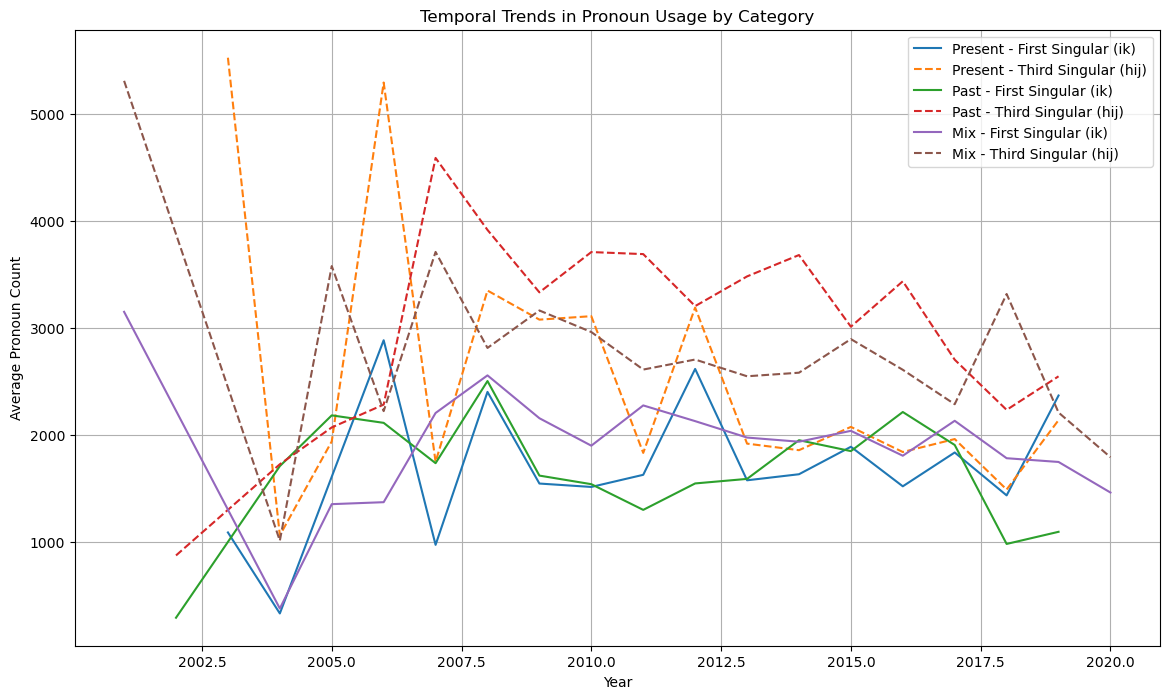

In [96]:
# Merge work_year and category with pronoun counts
temporal_category_df = personal_pronoun_counts_df.merge(
    meta_df[['isbn', 'work_year', 'category']], on='isbn', how='left'
)

# Filter out rows with missing years or categories
temporal_category_df = temporal_category_df.dropna(subset=['work_year', 'category'])

# Convert work_year to integer for proper sorting
temporal_category_df['work_year'] = temporal_category_df['work_year'].astype(int)

# Group by work_year and category, compute average counts
yearly_trends_by_category = (
    temporal_category_df.groupby(['work_year', 'category'])[['first_singular', 'third_singular']]
    .mean()
    .reset_index()
)

# Plot temporal trends by category
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

# Plot for each category
categories = temporal_category_df['category'].unique()
for category in categories:
    subset = yearly_trends_by_category[yearly_trends_by_category['category'] == category]
    plt.plot(
        subset['work_year'],
        subset['first_singular'],
        label=f'{category.capitalize()} - First Singular (ik)',
        linestyle='-'
    )
    plt.plot(
        subset['work_year'],
        subset['third_singular'],
        label=f'{category.capitalize()} - Third Singular (hij)',
        linestyle='--'
    )

plt.title('Temporal Trends in Pronoun Usage by Category')
plt.xlabel('Year')
plt.ylabel('Average Pronoun Count')
plt.legend()
plt.grid(True)
plt.show()



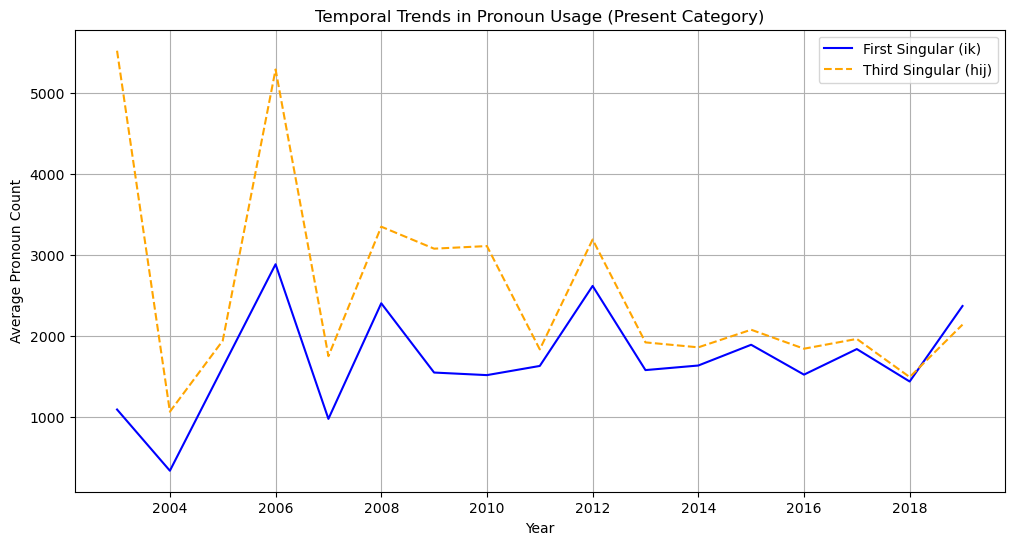

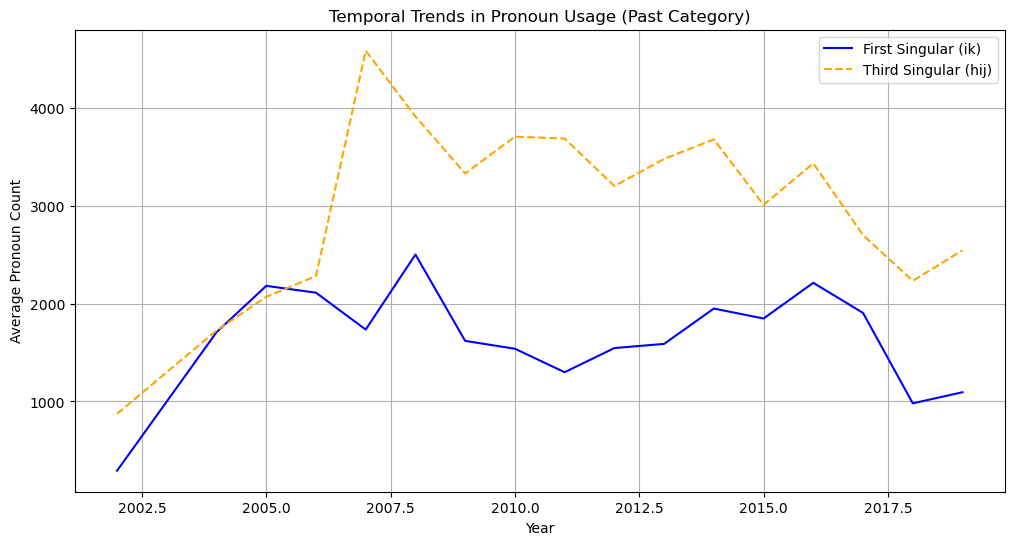

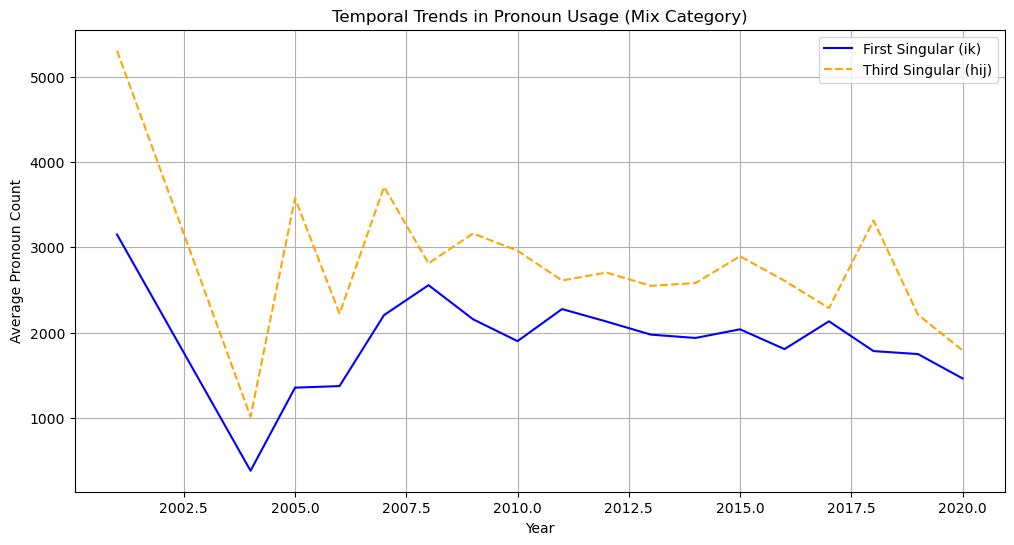

In [97]:
# Plot temporal trends by category with separate graphs
categories = temporal_category_df['category'].unique()

# Create a separate plot for each category
for category in categories:
    subset = yearly_trends_by_category[yearly_trends_by_category['category'] == category]
    
    plt.figure(figsize=(12, 6))
    plt.plot(
        subset['work_year'],
        subset['first_singular'],
        label='First Singular (ik)',
        linestyle='-',
        color='blue'
    )
    plt.plot(
        subset['work_year'],
        subset['third_singular'],
        label='Third Singular (hij)',
        linestyle='--',
        color='orange'
    )
    
    plt.title(f'Temporal Trends in Pronoun Usage ({category.capitalize()} Category)')
    plt.xlabel('Year')
    plt.ylabel('Average Pronoun Count')
    plt.legend()
    plt.grid(True)
    plt.show()


## Pronoun clustering

/Users/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster vs Category Comparison:
category  mix  past  present
cluster                     
0         292   426      206
1         575   690      545
2          61    60       21


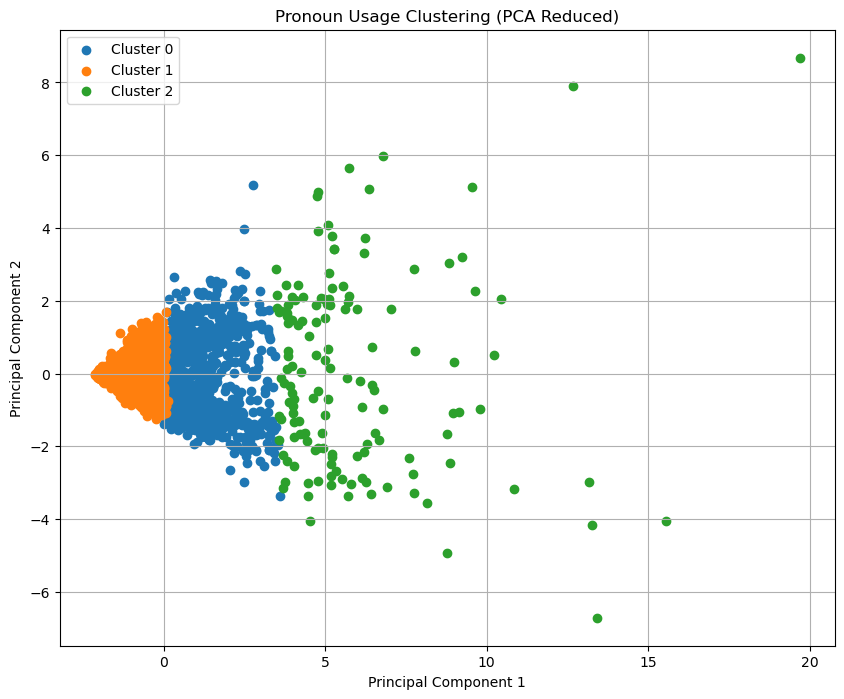

In [99]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Prepare features for clustering
features = ['first_singular', 'third_singular', 'first_plural', 'third_plural', 'second_singular', 'second_plural']
X = merged_df[features]

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply k-means clustering
n_clusters = 3  # Number of categories
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
merged_df['cluster'] = kmeans.fit_predict(X_scaled)

# Compare clusters with actual categories
cluster_category_comparison = pd.crosstab(merged_df['cluster'], merged_df['category'])
print("Cluster vs Category Comparison:")
print(cluster_category_comparison)

# Visualize clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
for cluster in range(n_clusters):
    cluster_points = X_pca[merged_df['cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')

plt.title('Pronoun Usage Clustering (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()



## Heatmap

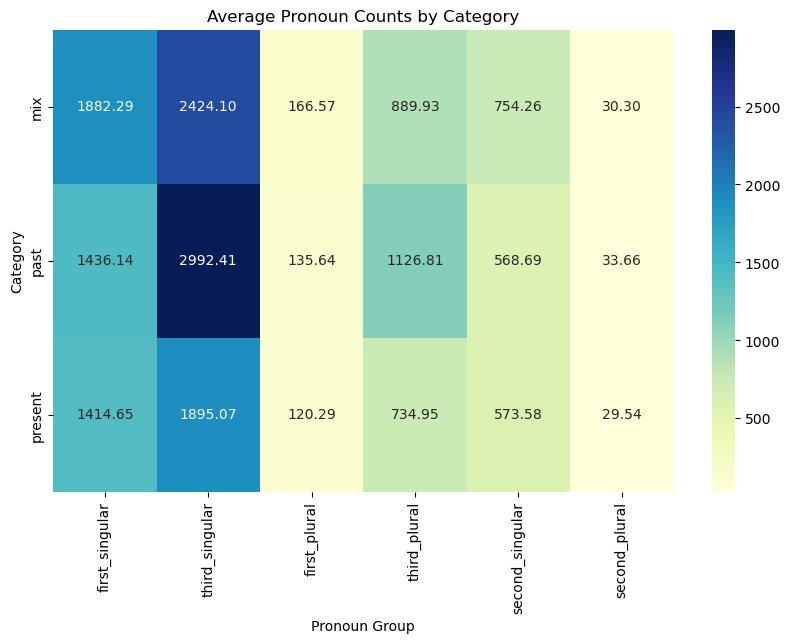

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute mean pronoun counts for each category
heatmap_data = merged_df.groupby('category')[['first_singular', 'third_singular', 'first_plural', 'third_plural', 'second_singular', 'second_plural']].mean()

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title('Average Pronoun Counts by Category')
plt.ylabel('Category')
plt.xlabel('Pronoun Group')
plt.show()


# Focus only on 'ik' and 'hij'

In [134]:
def count_ik_hij_with_upos(parsed_isbns, data_dir):
    all_counts = []
    
    for isbn in parsed_isbns:
        book_tokens = read_book_tokens(isbn, data_dir)
        counts = defaultdict(int)
        
        # Count occurrences of 'ik' and 'hij' with upos filter
        for token in book_tokens:
            word = token['text'].lower()
            upos = token.get('upos', '')
            
            if upos == 'PRON' and word in ['ik', 'hij']:
                counts[word] += 1
        
        # Add counts to results
        counts['isbn'] = isbn
        all_counts.append(counts)
    
    return pd.DataFrame(all_counts).fillna(0)

# Count occurrences of 'ik' and 'hij'
ik_hij_df = count_ik_hij_with_upos(parsed_isbns, data_dir)

# Merge with meta_df to include categories
ik_hij_df = ik_hij_df.merge(meta_df[['isbn', 'category']], on='isbn', how='left')

# Filter for relevant categories
ik_hij_df = ik_hij_df[ik_hij_df['category'].isin(['present', 'past'])]

# Compute means and perform t-tests as before
means = ik_hij_df.groupby('category')[['ik', 'hij']].mean()
print("Average Counts by Category:")
print(means)

# Perform t-tests
ttest_ik = ttest_ind(ik_hij_df[ik_hij_df['category'] == 'present']['ik'], 
                     ik_hij_df[ik_hij_df['category'] == 'past']['ik'], 
                     equal_var=False)

ttest_hij = ttest_ind(ik_hij_df[ik_hij_df['category'] == 'present']['hij'], 
                      ik_hij_df[ik_hij_df['category'] == 'past']['hij'], 
                      equal_var=False)

print("\nT-Test Results:")
print(f"'ik': t-statistic = {ttest_ik.statistic}, p-value = {ttest_ik.pvalue}")
print(f"'hij': t-statistic = {ttest_hij.statistic}, p-value = {ttest_hij.pvalue}")



Average Counts by Category:
                  ik          hij
category                         
past      929.917517  1024.568027
present   911.844560   594.729275

T-Test Results:
'ik': t-statistic = -0.3234898949077799, p-value = 0.7463729722854546
'hij': t-statistic = -10.555284340768848, p-value = 2.439214207451809e-25


## Permutation test 'ik' and 'hij'

Permutation Test Results:
'ik': Observed Difference = -18.072957421310548, p-value = 0.7324
'hij': Observed Difference = -429.83875259948536, p-value = 0.0


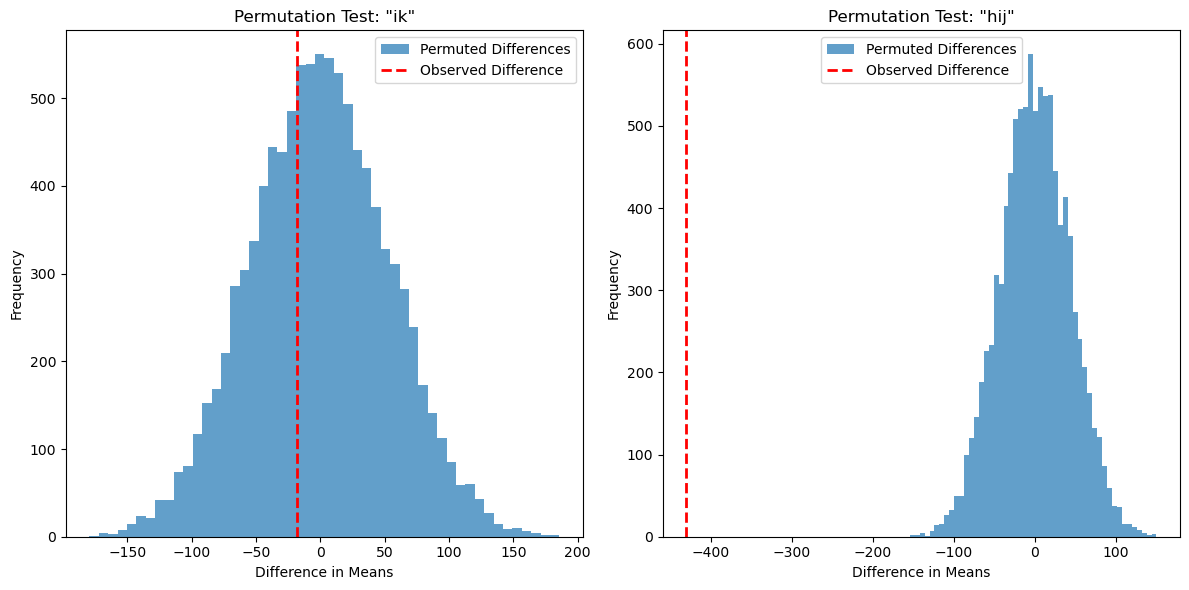

In [135]:
import numpy as np

def permutation_test(data, group_col, value_col, group1, group2, n_permutations=10000):
    # Observed difference
    group1_vals = data[data[group_col] == group1][value_col]
    group2_vals = data[data[group_col] == group2][value_col]
    observed_diff = group1_vals.mean() - group2_vals.mean()
    
    # Combine data and shuffle
    combined = np.concatenate([group1_vals, group2_vals])
    permuted_diffs = []
    
    for _ in range(n_permutations):
        np.random.shuffle(combined)
        perm_group1 = combined[:len(group1_vals)]
        perm_group2 = combined[len(group1_vals):]
        permuted_diffs.append(perm_group1.mean() - perm_group2.mean())
    
    # Calculate p-value
    permuted_diffs = np.array(permuted_diffs)
    p_value = np.mean(np.abs(permuted_diffs) >= np.abs(observed_diff))
    
    return observed_diff, permuted_diffs, p_value

# Perform permutation tests for 'ik' and 'hij'
obs_diff_ik, perm_diffs_ik, p_value_ik = permutation_test(
    ik_hij_df, 'category', 'ik', 'present', 'past'
)
obs_diff_hij, perm_diffs_hij, p_value_hij = permutation_test(
    ik_hij_df, 'category', 'hij', 'present', 'past'
)

# Print results
print("Permutation Test Results:")
print(f"'ik': Observed Difference = {obs_diff_ik}, p-value = {p_value_ik}")
print(f"'hij': Observed Difference = {obs_diff_hij}, p-value = {p_value_hij}")

# Visualize permutation results
plt.figure(figsize=(12, 6))

# Plot for 'ik'
plt.subplot(1, 2, 1)
plt.hist(perm_diffs_ik, bins=50, alpha=0.7, label='Permuted Differences')
plt.axvline(obs_diff_ik, color='red', linestyle='dashed', linewidth=2, label='Observed Difference')
plt.title('Permutation Test: "ik"')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.legend()

# Plot for 'hij'
plt.subplot(1, 2, 2)
plt.hist(perm_diffs_hij, bins=50, alpha=0.7, label='Permuted Differences')
plt.axvline(obs_diff_hij, color='red', linestyle='dashed', linewidth=2, label='Observed Difference')
plt.title('Permutation Test: "hij"')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


# Check for only literary_fiction

In [136]:
# Merge 'nur_genre' from meta_df into personal_pronoun_counts_df
personal_pronoun_counts_df = personal_pronoun_counts_df.merge(
    meta_df[['isbn', 'nur_genre']], on='isbn', how='left'
)

# Display the first few rows to confirm the merge
print(personal_pronoun_counts_df.head())
print(f"Columns in personal_pronoun_counts_df: {personal_pronoun_counts_df.columns}")



   first_plural  third_singular  demonstrative  first_singular  third_plural  \
0         261.0            2135          569.0          2296.0         422.0   
1         274.0            3203         1669.0          6862.0        1212.0   
2           8.0              98           34.0           117.0          20.0   
3          71.0            2387          709.0           176.0         684.0   
4          29.0            5254         1113.0          1494.0        1232.0   

   second_singular  second_plural           isbn  genre          nur_genre  
0            662.0           56.0  9789044623550      0      Other fiction  
1           1343.0          122.0  9789021449760      0        Young_adult  
2             29.0            0.0  9789029590280      0   Literary_fiction  
3             95.0            1.0  9789044626674      0   Literary_fiction  
4           1163.0           24.0  9789021441955      0  Literary_thriller  
Columns in personal_pronoun_counts_df: Index(['first_plur

In [137]:
# Drop unnecessary duplicate columns
personal_pronoun_counts_df = personal_pronoun_counts_df.drop(columns=['nur_genre_x', 'nur_genre_y'], errors='ignore')

# Check unique values in the remaining 'nur_genre' column
print(personal_pronoun_counts_df['nur_genre'].unique())

# Filter for 'literary_fiction'
literary_fiction_df = personal_pronoun_counts_df[
    personal_pronoun_counts_df['nur_genre'] == 'Literary_fiction'
]

# Display the filtered DataFrame
print(literary_fiction_df.head())
print(f"Number of literary fiction books: {len(literary_fiction_df)}")


['Other fiction' 'Young_adult' 'Literary_fiction' 'Literary_thriller'
 'Non-fiction' nan 'Children_fiction' 'Suspense']
    first_plural  third_singular  demonstrative  first_singular  third_plural  \
2            8.0              98           34.0           117.0          20.0   
3           71.0            2387          709.0           176.0         684.0   
8          122.0            1482          353.0           523.0         486.0   
10         373.0            2813         1435.0          4862.0         940.0   
11          77.0            1334          514.0          1461.0         483.0   

    second_singular  second_plural           isbn  genre         nur_genre  
2              29.0            0.0  9789029590280      0  Literary_fiction  
3              95.0            1.0  9789044626674      0  Literary_fiction  
8             306.0            9.0  9789025863524      0  Literary_fiction  
10           1207.0           32.0  9789029587495      0  Literary_fiction  
11      

In [138]:
# Rename the DataFrame
lit_fic_pronouns_df = literary_fiction_df

# Display the renamed DataFrame
print(lit_fic_pronouns_df.head())
print(f"Number of literary fiction books: {len(lit_fic_pronouns_df)}")

    first_plural  third_singular  demonstrative  first_singular  third_plural  \
2            8.0              98           34.0           117.0          20.0   
3           71.0            2387          709.0           176.0         684.0   
8          122.0            1482          353.0           523.0         486.0   
10         373.0            2813         1435.0          4862.0         940.0   
11          77.0            1334          514.0          1461.0         483.0   

    second_singular  second_plural           isbn  genre         nur_genre  
2              29.0            0.0  9789029590280      0  Literary_fiction  
3              95.0            1.0  9789044626674      0  Literary_fiction  
8             306.0            9.0  9789025863524      0  Literary_fiction  
10           1207.0           32.0  9789029587495      0  Literary_fiction  
11            405.0            5.0  9789029581134      0  Literary_fiction  
Number of literary fiction books: 1792


In [139]:
# Merge 'category' from meta_df into lit_fic_pronouns_df
lit_fic_pronouns_df = lit_fic_pronouns_df.merge(
    meta_df[['isbn', 'category']], on='isbn', how='left'
)

# Verify the merge
print("Categories in lit_fic_pronouns_df:", lit_fic_pronouns_df['category'].unique())
print(lit_fic_pronouns_df.head())


Categories in lit_fic_pronouns_df: ['mix' 'past' 'present']
   first_plural  third_singular  demonstrative  first_singular  third_plural  \
0           8.0              98           34.0           117.0          20.0   
1          71.0            2387          709.0           176.0         684.0   
2         122.0            1482          353.0           523.0         486.0   
3         373.0            2813         1435.0          4862.0         940.0   
4          77.0            1334          514.0          1461.0         483.0   

   second_singular  second_plural           isbn  genre         nur_genre  \
0             29.0            0.0  9789029590280      0  Literary_fiction   
1             95.0            1.0  9789044626674      0  Literary_fiction   
2            306.0            9.0  9789025863524      0  Literary_fiction   
3           1207.0           32.0  9789029587495      0  Literary_fiction   
4            405.0            5.0  9789029581134      0  Literary_fiction 

In [140]:
# Drop the empty 'genre' column
lit_fic_pronouns_df = lit_fic_pronouns_df.drop(columns=['genre'], errors='ignore')

# Verify the column is removed
print("Columns in lit_fic_pronouns_df after dropping 'genre':", lit_fic_pronouns_df.columns)


Columns in lit_fic_pronouns_df after dropping 'genre': Index(['first_plural', 'third_singular', 'demonstrative', 'first_singular',
       'third_plural', 'second_singular', 'second_plural', 'isbn', 'nur_genre',
       'category'],
      dtype='object')


In [141]:
from scipy.stats import ttest_ind

# Filter the data for 'past' and 'present' categories
past_df = lit_fic_pronouns_df[lit_fic_pronouns_df['category'] == 'past']
present_df = lit_fic_pronouns_df[lit_fic_pronouns_df['category'] == 'present']

# Perform T-tests
# First Singular (ik)
t_test_first_singular = ttest_ind(
    present_df['first_singular'], past_df['first_singular'], equal_var=False
)

# Third Singular (hij)
t_test_third_singular = ttest_ind(
    present_df['third_singular'], past_df['third_singular'], equal_var=False
)

# Print the results
print("T-Test Results for First Singular (ik):")
print(f"T-statistic: {t_test_first_singular.statistic}")
print(f"P-value: {t_test_first_singular.pvalue}")

print("\nT-Test Results for Third Singular (hij):")
print(f"T-statistic: {t_test_third_singular.statistic}")
print(f"P-value: {t_test_third_singular.pvalue}")


T-Test Results for First Singular (ik):
T-statistic: 1.580099790215532
P-value: 0.11466132633722449

T-Test Results for Third Singular (hij):
T-statistic: -4.109135820189036
P-value: 4.3502929047503206e-05


Permutation Test Results:
'ik': Observed Difference = 247.63058099573573, p-value = 0.0738
'hij': Observed Difference = -685.9095165266208, p-value = 0.0001


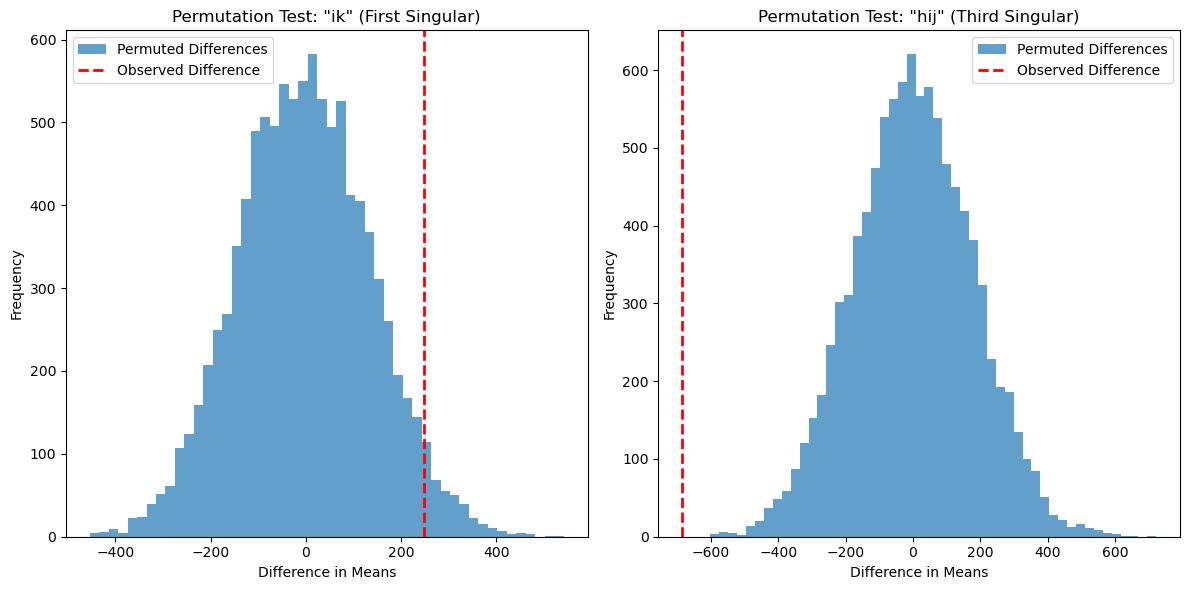

In [131]:
import numpy as np

# Permutation test function
def permutation_test(data, group_col, value_col, group1, group2, n_permutations=10000):
    # Observed difference
    group1_vals = data[data[group_col] == group1][value_col]
    group2_vals = data[data[group_col] == group2][value_col]
    observed_diff = group1_vals.mean() - group2_vals.mean()
    
    # Combine data and shuffle
    combined = np.concatenate([group1_vals, group2_vals])
    permuted_diffs = []
    
    for _ in range(n_permutations):
        np.random.shuffle(combined)
        perm_group1 = combined[:len(group1_vals)]
        perm_group2 = combined[len(group1_vals):]
        permuted_diffs.append(perm_group1.mean() - perm_group2.mean())
    
    # Calculate p-value
    permuted_diffs = np.array(permuted_diffs)
    p_value = np.mean(np.abs(permuted_diffs) >= np.abs(observed_diff))
    
    return observed_diff, permuted_diffs, p_value

# Perform permutation tests for first_singular (ik)
obs_diff_ik, perm_diffs_ik, p_value_ik = permutation_test(
    lit_fic_pronouns_df, 'category', 'first_singular', 'present', 'past'
)

# Perform permutation tests for third_singular (hij)
obs_diff_hij, perm_diffs_hij, p_value_hij = permutation_test(
    lit_fic_pronouns_df, 'category', 'third_singular', 'present', 'past'
)

# Print results
print("Permutation Test Results:")
print(f"'ik': Observed Difference = {obs_diff_ik}, p-value = {p_value_ik}")
print(f"'hij': Observed Difference = {obs_diff_hij}, p-value = {p_value_hij}")

# Visualize permutation results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot for 'ik'
plt.subplot(1, 2, 1)
plt.hist(perm_diffs_ik, bins=50, alpha=0.7, label='Permuted Differences')
plt.axvline(obs_diff_ik, color='red', linestyle='dashed', linewidth=2, label='Observed Difference')
plt.title('Permutation Test: "ik" (First Singular)')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.legend()

# Plot for 'hij'
plt.subplot(1, 2, 2)
plt.hist(perm_diffs_hij, bins=50, alpha=0.7, label='Permuted Differences')
plt.axvline(obs_diff_hij, color='red', linestyle='dashed', linewidth=2, label='Observed Difference')
plt.title('Permutation Test: "hij" (Third Singular)')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


## Let's look separately on 'ik' and 'hij' in literary fiction

In [142]:
# Merge 'ik' and 'hij' counts from ik_hij_df into lit_fic_pronouns_df
lit_fic_ik_hij_df = lit_fic_pronouns_df.merge(
    ik_hij_df[['isbn', 'ik', 'hij']], on='isbn', how='left'
)

# Verify the merge
print(lit_fic_ik_hij_df.head())
print(f"Number of rows in lit_fic_ik_hij_df: {len(lit_fic_ik_hij_df)}")

   first_plural  third_singular  demonstrative  first_singular  third_plural  \
0           8.0              98           34.0           117.0          20.0   
1          71.0            2387          709.0           176.0         684.0   
2         122.0            1482          353.0           523.0         486.0   
3         373.0            2813         1435.0          4862.0         940.0   
4          77.0            1334          514.0          1461.0         483.0   

   second_singular  second_plural           isbn         nur_genre category  \
0             29.0            0.0  9789029590280  Literary_fiction      mix   
1             95.0            1.0  9789044626674  Literary_fiction     past   
2            306.0            9.0  9789025863524  Literary_fiction     past   
3           1207.0           32.0  9789029587495  Literary_fiction      mix   
4            405.0            5.0  9789029581134  Literary_fiction      mix   

      ik    hij  
0    NaN    NaN  
1  127.0

In [143]:
# Find missing ISBNs
missing_isbns = lit_fic_pronouns_df[~lit_fic_pronouns_df['isbn'].isin(ik_hij_df['isbn'])]

# Print results
print(f"Number of missing ISBNs: {len(missing_isbns)}")
if not missing_isbns.empty:
    print("Missing ISBNs:")
    print(missing_isbns['isbn'].tolist())
else:
    print("All ISBNs from lit_fic_pronouns_df are present in ik_hij_df.")


Number of missing ISBNs: 674
Missing ISBNs:
['9789029590280', '9789029587495', '9789029581134', '9789025365295', '9789029591997', '9789029592178', '9789029581301', '9789029581561', '9789021445168', '9789038896991', '9789021446974', '9789044617337', '9789029568661', '9789029578097', '9789029585569', '9789029577014', '9789044619430', '9789021440422', '9789038898858', '9789021446547', '9789038897448', '9789021444680', '9789029590440', '9789029577281', '9789021445755', '9789021444819', '9789038898063', '9789029581158', '9789021435619', '9789044618914', '9789029591133', '9789029577618', '9789021436296', '9789044629491', '9789038894492', '9789044629668', '9789038895918', '9789021456942', '9789029580687', '9789044629439', '9789021444048', '9789029576765', '9789029586917', '9789021444413', '9789029590082', '9789029591362', '9789044624113', '9789044625035', '9789044619409', '9789025304430', '9789029577229', '9789021449302', '9789038895512', '9789025368920', '9789029591195', '9789029582582', '97

In [144]:
# Drop rows with NaN values in 'ik' or 'hij'
lit_fic_ik_hij_df_cleaned = lit_fic_ik_hij_df.dropna(subset=['ik', 'hij'])

# Verify the cleaned DataFrame
print(f"Number of rows after dropping NaN: {len(lit_fic_ik_hij_df_cleaned)}")
print(lit_fic_ik_hij_df_cleaned.head())


Number of rows after dropping NaN: 1118
   first_plural  third_singular  demonstrative  first_singular  third_plural  \
1          71.0            2387          709.0           176.0         684.0   
2         122.0            1482          353.0           523.0         486.0   
6          19.0            2322          339.0           228.0         756.0   
8          46.0           13858         2313.0          1033.0        5908.0   
9         235.0            3005          762.0          3021.0        1067.0   

   second_singular  second_plural           isbn         nur_genre category  \
1             95.0            1.0  9789044626674  Literary_fiction     past   
2            306.0            9.0  9789025863524  Literary_fiction     past   
6             99.0            0.0  9789038897288  Literary_fiction     past   
8           1271.0           47.0  9789021444888  Literary_fiction     past   
9            820.0           68.0  9789038896168  Literary_fiction     past   

    

In [145]:
from scipy.stats import ttest_ind

# Filter data for 'present' and 'past' categories
present_counts = lit_fic_ik_hij_df_cleaned[lit_fic_ik_hij_df_cleaned['category'] == 'present']
past_counts = lit_fic_ik_hij_df_cleaned[lit_fic_ik_hij_df_cleaned['category'] == 'past']

# Perform T-tests
# First Singular (ik)
t_test_ik = ttest_ind(
    present_counts['ik'], past_counts['ik'], equal_var=False
)

# Third Singular (hij)
t_test_hij = ttest_ind(
    present_counts['hij'], past_counts['hij'], equal_var=False
)

# Print results
print("T-Test Results:")
print(f"'ik': t-statistic = {t_test_ik.statistic}, p-value = {t_test_ik.pvalue}")
print(f"'hij': t-statistic = {t_test_hij.statistic}, p-value = {t_test_hij.pvalue}")


T-Test Results:
'ik': t-statistic = 1.6730381874479527, p-value = 0.0948830516860044
'hij': t-statistic = -4.530701406001397, p-value = 6.771666121530119e-06


Permutation Test Results:
'ik': Observed Difference = 156.27045360490843, p-value = 0.0557
'hij': Observed Difference = -294.5175018442882, p-value = 0.0


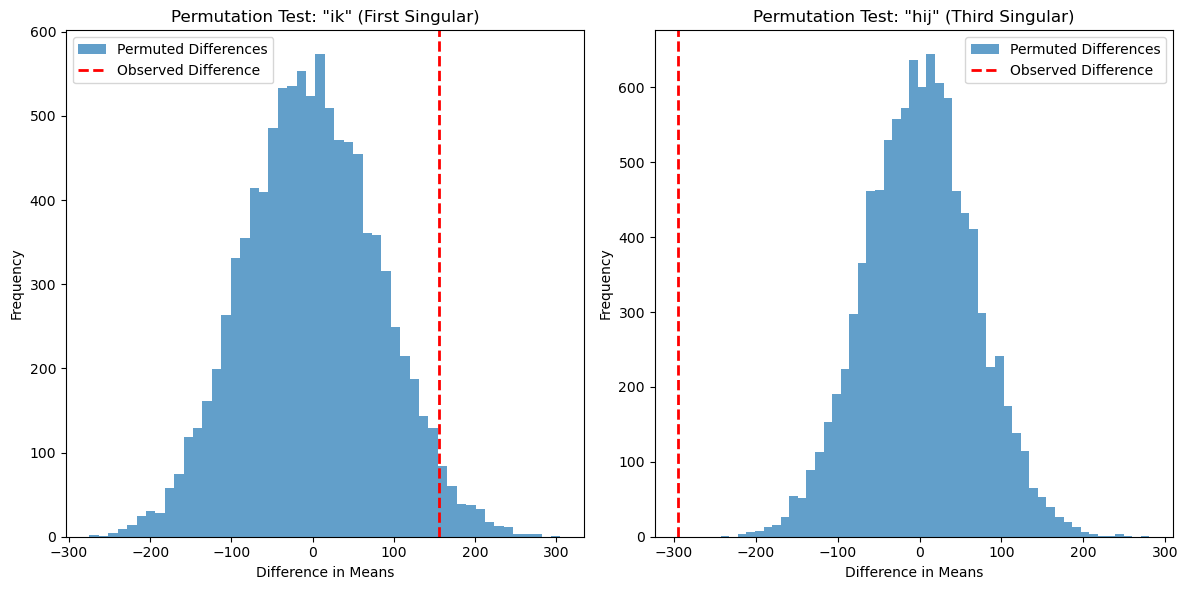

In [146]:
import numpy as np

# Permutation test function
def permutation_test(data, group_col, value_col, group1, group2, n_permutations=10000):
    # Observed difference
    group1_vals = data[data[group_col] == group1][value_col]
    group2_vals = data[data[group_col] == group2][value_col]
    observed_diff = group1_vals.mean() - group2_vals.mean()
    
    # Combine data and shuffle
    combined = np.concatenate([group1_vals, group2_vals])
    permuted_diffs = []
    
    for _ in range(n_permutations):
        np.random.shuffle(combined)
        perm_group1 = combined[:len(group1_vals)]
        perm_group2 = combined[len(group1_vals):]
        permuted_diffs.append(perm_group1.mean() - perm_group2.mean())
    
    # Calculate p-value
    permuted_diffs = np.array(permuted_diffs)
    p_value = np.mean(np.abs(permuted_diffs) >= np.abs(observed_diff))
    
    return observed_diff, permuted_diffs, p_value

# Perform permutation test for 'ik'
obs_diff_ik, perm_diffs_ik, p_value_ik = permutation_test(
    lit_fic_ik_hij_df_cleaned, 'category', 'ik', 'present', 'past'
)

# Perform permutation test for 'hij'
obs_diff_hij, perm_diffs_hij, p_value_hij = permutation_test(
    lit_fic_ik_hij_df_cleaned, 'category', 'hij', 'present', 'past'
)

# Print results
print("Permutation Test Results:")
print(f"'ik': Observed Difference = {obs_diff_ik}, p-value = {p_value_ik}")
print(f"'hij': Observed Difference = {obs_diff_hij}, p-value = {p_value_hij}")

# Visualize permutation results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot for 'ik'
plt.subplot(1, 2, 1)
plt.hist(perm_diffs_ik, bins=50, alpha=0.7, label='Permuted Differences')
plt.axvline(obs_diff_ik, color='red', linestyle='dashed', linewidth=2, label='Observed Difference')
plt.title('Permutation Test: "ik" (First Singular)')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.legend()

# Plot for 'hij'
plt.subplot(1, 2, 2)
plt.hist(perm_diffs_hij, bins=50, alpha=0.7, label='Permuted Differences')
plt.axvline(obs_diff_hij, color='red', linestyle='dashed', linewidth=2, label='Observed Difference')
plt.title('Permutation Test: "hij" (Third Singular)')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [148]:
merged_df.columns

Index(['first_plural', 'third_singular', 'demonstrative', 'first_singular',
       'third_plural', 'second_singular', 'second_plural', 'isbn', 'category',
       'cluster'],
      dtype='object')

# ANOVA for pronouns per category

In [149]:
from scipy.stats import f_oneway

# Test voor elke voornaamwoordgroep
pronoun_columns = ['first_plural', 'third_singular', 'demonstrative', 
                   'first_singular', 'third_plural', 'second_singular', 'second_plural']

for col in pronoun_columns:
    f_stat, p_value = f_oneway(
        merged_df[merged_df['category'] == 'present'][col],
        merged_df[merged_df['category'] == 'past'][col],
        merged_df[merged_df['category'] == 'mix'][col]
    )
    print(f"ANOVA Results for {col}: F-statistic = {f_stat:.4f}, p-value = {p_value:.4e}")


ANOVA Results for first_plural: F-statistic = 15.4611, p-value = 2.0951e-07
ANOVA Results for third_singular: F-statistic = 47.4626, p-value = 5.2535e-21
ANOVA Results for demonstrative: F-statistic = 31.7438, p-value = 2.3119e-14
ANOVA Results for first_singular: F-statistic = 18.8933, p-value = 7.0509e-09
ANOVA Results for third_plural: F-statistic = 41.7473, p-value = 1.3422e-18
ANOVA Results for second_singular: F-statistic = 23.9508, p-value = 4.8311e-11
ANOVA Results for second_plural: F-statistic = 2.0438, p-value = 1.2973e-01


#Relatieve verhoudingen

Average Pronoun Ratios by Category:
          first_plural_ratio  third_singular_ratio  demonstrative_ratio  \
category                                                                  
mix                 0.026117              0.344350             0.121392   
past                0.020594              0.426836             0.105881   
present             0.026971              0.354353             0.114308   

          first_singular_ratio  third_plural_ratio  second_singular_ratio  \
category                                                                    
mix                   0.272771            0.127473               0.103706   
past                  0.205971            0.156563               0.079051   
present               0.236452            0.147297               0.114172   

          second_plural_ratio  
category                       
mix                  0.004192  
past                 0.005104  
present              0.006447  


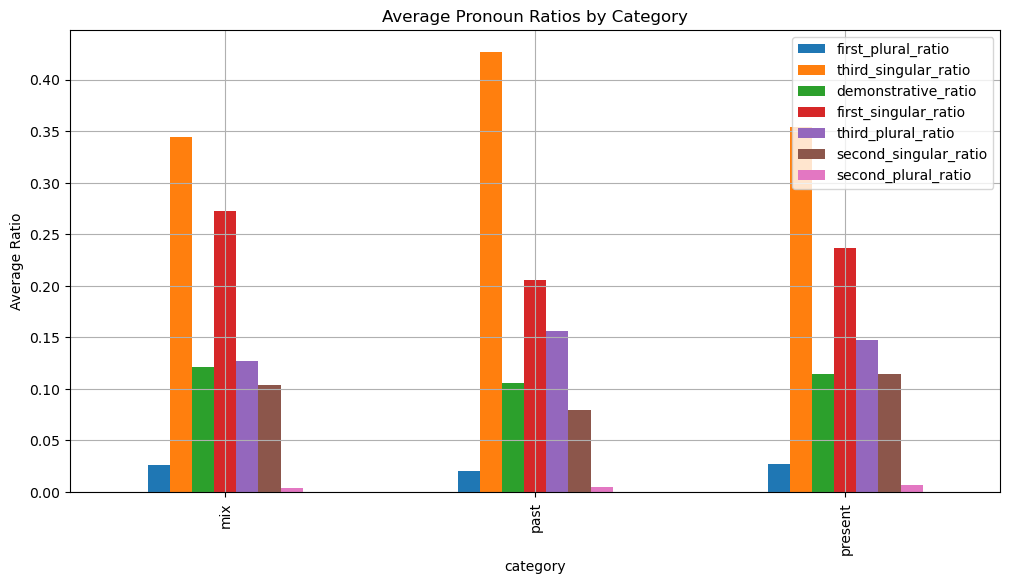

In [150]:
# Bereken totalen en verhoudingen
merged_df['total_pronouns'] = merged_df[pronoun_columns].sum(axis=1)
for col in pronoun_columns:
    merged_df[f'{col}_ratio'] = merged_df[col] / merged_df['total_pronouns']

# Gemiddelden van verhoudingen per categorie
ratio_means = merged_df.groupby('category')[[f'{col}_ratio' for col in pronoun_columns]].mean()
print("Average Pronoun Ratios by Category:")
print(ratio_means)

# Visualisatie
ratio_means.plot(kind='bar', figsize=(12, 6), title='Average Pronoun Ratios by Category')
plt.ylabel('Average Ratio')
plt.grid(True)
plt.show()
